# Pause Sites

In [1]:
import ribopy
import numpy as np
import pandas as pd
import math

import scipy
import scipy.stats as stats
import matplotlib
import h5py

from collections import OrderedDict
import random
from multiprocessing import Pool
from functools import partial
import pickle
from collections import OrderedDict, defaultdict

from ribopy.core.get_gadgets import get_region_boundaries
from IPython.display import display_html

In [2]:
# Widget and other plotting Functions

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
# Import the manuscript 
import sys

sys.path.append('.')
from manuscript_colors import *

In [4]:
ribo_path = "../manuscript.ribo"

def rename(x):
    return x.split("|")[4]

myribo = ribopy.Ribo(ribo_path, alias=rename)

In [5]:
NSP1_experiments = ["20200717-NSP1-HEK-1-setB",
                    "20200717-NSP1-HEK-2-setB",
                    "20200717-NSP1-HEK-3-setB"]

NSP2_experiments = ["20200717-NSP2-HEK-1-setB",
                    "20200717-NSP2-HEK-2-setB",
                    "20200717-NSP2-HEK-3-setB"]

WT_experiments = ["20200717-WT-HEK-1-setB",
                  "20200717-WT-HEK-2-setB",
                  "20200717-WT-HEK-3-setB"]

all_experiments = NSP1_experiments + NSP2_experiments + WT_experiments

In [6]:
# CAN's interval
LENGTH_MIN  = 28
LENGTH_MAX  = 35

COVERAGE_THRESHOLD = 1
FIGURE_RESOLUTION  = 600

In [7]:
def get_coverage(ribo, 
                 experiment,
                 range_lower = 0,
                 range_upper = 0,
                 alias       = False,
                 multiplier  = 1):
    """
    NOTE THAT THIS FUNCTION RETURNS A TUPLE!!!
    
    Returns a pair: (dataframe, coverage_dict)
    
    In the dataframe, the last column 
    has the coverage density of a given transcript.
    The normalized covarage is defined by
    (#total_reads / #transcript_length) * 1000000
    
    coverage_dict: This is the output of the function "get_coverage"
    of the ribo object. It contains the coverage values of each gene 
    at nucleotide resolution.

    """
    
    coverage_dict = ribo.get_coverage(experiment  = experiment,
                                      range_lower = range_lower, 
                                      range_upper = range_upper,
                                      alias       = alias)
    
    region_boundaries = get_region_boundaries(ribo._handle)
    
    transcript_names     = coverage_dict.keys()
    transcript_coverages = coverage_dict.values()
    transcript_total     = tuple( map( np.sum, transcript_coverages ) )
    transcript_lengths   = tuple( map(len, transcript_coverages) )
    normalized_coverage  = np.divide(transcript_total , transcript_lengths) * multiplier
    start_sites          = tuple( map( lambda x: x[1][0], region_boundaries ) )
    stop_sites           = tuple( map( lambda x: x[1][1], region_boundaries ) )
    
    # We also add normalized cds coverage
    cds_data = zip( start_sites, stop_sites, transcript_coverages )
    norm_cds = tuple( map( lambda x:  
                              (np.sum( x[2][x[0]:x[1]] ) / (x[1] - x[0]) )* multiplier,
                      cds_data) )
    
    result = pd.DataFrame(data = { "total"     :  transcript_total, 
                                   "length"    :  transcript_lengths,
                                   "cds_start" :  start_sites,
                                   "cds_stop"  :  stop_sites,
                                   "norm_cds"  :  norm_cds,
                                   "norm_cov"  :  normalized_coverage}, 
                          index = transcript_names) 
    
    return( (result, coverage_dict))


coverages = { e: get_coverage(
                     ribo        = myribo, 
                     experiment  = e,
                     range_lower = LENGTH_MIN,
                     range_upper = LENGTH_MAX,
                     alias       = rename)\
                 for e in NSP1_experiments + NSP2_experiments + WT_experiments }

In [8]:
coverages["20200717-NSP1-HEK-1-setB"][0].sort_values(by = "norm_cds", ascending = False)[0:20]

,total,length,cds_start,cds_stop,norm_cds,norm_cov
EEF1A1-202,75931,4441,992,2378,52.337662,17.097726
RPL41-204,4165,699,202,277,48.706667,5.958512
RACK1-227,32381,1403,409,1360,33.667718,23.079829
RPS4X-201,25735,1526,105,894,32.357414,16.864351
NPM1-201,27233,1758,301,1183,29.736961,15.490899
RPL38-201,6425,1170,131,341,29.257143,5.491453
RPL5-208,26277,1085,132,1023,29.255892,24.218433
GAPDH-201,27970,1875,666,1671,27.428856,14.917333
RPL23-206,11363,2821,133,553,26.761905,4.028004
ACTB-201,30018,1921,192,1317,25.817778,15.626236


In [9]:
coverages["20200717-NSP1-HEK-1-setB"][0].loc["RPL41-204", "cds_start"]

202

## Selection of Genes

In [10]:
NSP1_sets = dict()

for e in NSP1_experiments:
    NSP1_sets[e] = set( coverages[e][0][ (coverages[e][0].norm_cds>=COVERAGE_THRESHOLD ) ].index)
    
NSP1_intersection = NSP1_sets["20200717-NSP1-HEK-1-setB"].\
                       intersection(NSP1_sets["20200717-NSP1-HEK-2-setB"], 
                                    NSP1_sets["20200717-NSP1-HEK-3-setB"])

NSP2_sets = dict()

for e in NSP2_experiments:
    NSP2_sets[e] = set( coverages[e][0][ (coverages[e][0].norm_cds>=COVERAGE_THRESHOLD) ].index)
    
NSP2_intersection = NSP2_sets["20200717-NSP2-HEK-1-setB"].\
                      intersection(NSP2_sets["20200717-NSP2-HEK-2-setB"], 
                                   NSP2_sets["20200717-NSP2-HEK-3-setB"])

WT_sets = dict()

for e in WT_experiments:
    WT_sets[e] = set( coverages[e][0][ (coverages[e][0].norm_cds>=COVERAGE_THRESHOLD ) ].index)
    
WT_intersection = WT_sets[WT_experiments[0]].intersection( WT_sets[WT_experiments[1]], WT_sets[WT_experiments[2]] ) 

selected_genes = NSP1_intersection.union(NSP2_intersection, WT_intersection)
print("{} genes are selected".format(len(selected_genes) ))

1493 genes are selected


In [11]:
with open("selected_genes.csv", "wt") as output_stream:
    for g in selected_genes:
        print(g, file = output_stream)

## Background Distribution

We fit Negative Binomial to the distribution of the reads mapping to the CDS sequence.

Before fitting NB, we remove the top and bottom 5% of the values.

In [12]:
def fit_nb(distribution):
    """
    Returns the parameters of the negative binomial distribution.
    These parameters are compatible with those of scipy.stats.nbinom
    """
    
    moment_1 = np.mean(distribution)
    moment_2 = np.mean(np.square(distribution) )
    
    
    p_fail = moment_1 / (moment_2 - (moment_1 **2) )
    
    n         = (p_fail / (1-p_fail)) * moment_1
    
    return(n,p_fail)

n, p = 5, 0.1
sample = stats.nbinom.rvs(n, p, size=100000)

print(fit_nb(distribution = sample))
assert np.all(np.isclose( (n,p), fit_nb(distribution = sample) , atol = 0.1) )
    

(5.068942724896506, 0.10121827630820823)


In [13]:
def remove_top_and_bottom_outliers(gene_coverage, percentile = 5):
    """
    Removes the values at the top and bottom percentile
    from the gene_coverage array
    This will remove the outliers from the gene coverage background
    """
    
    bottom_value = np.percentile( gene_coverage, percentile )
    top_value    = np.percentile( gene_coverage, 100 - percentile )
    
    selected_indices = np.all( [gene_coverage > bottom_value, gene_coverage < top_value] , 
                               axis = 0)
 
    return gene_coverage[ selected_indices ]

assert remove_top_and_bottom_outliers( np.array(range(0,101))   )[0] == 6

In [14]:
def plot_coverage_distribution(coverage_dict,
                               experiment,
                               gene_name,
                               title        = "",
                               percentile   = 5,
                               threshold    = 0):
    """
    Threshold is the minimum number of reads required per position
    """
    
    transcript_coverage = coverage_dict[experiment][1][gene_name]
    
    
    # Get the CDS region coverage only
    cds_start    = coverage_dict[experiment][0].loc[gene_name, "cds_start"]
    cds_stop     = coverage_dict[experiment][0].loc[gene_name, "cds_stop"]
    cds_coverage = np.array(transcript_coverage[cds_start:cds_stop] )
    
    cds_coverage = remove_top_and_bottom_outliers(cds_coverage, percentile)
    filtered_coverage = cds_coverage[ cds_coverage > 0 ]
    
    log_cds_coverage = np.log2(filtered_coverage)
    this_coverage    = filtered_coverage 
    
    hist, bins  = np.histogram(this_coverage, 
                               bins    = "auto",
                               density = True )
    
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    
    fit_coordinates = [ i for i in range(math.floor(min(bins)), math.ceil(max(bins)) ) ]
    
    n, p = fit_nb(this_coverage)
    
    nb_fit = stats.nbinom.pmf( fit_coordinates , 
                          n, p )
    
    #print(  stats.poisson.pmf( bin_centers, 15)  )
    
    plt.bar(bin_centers, hist, width = 0.50)
    print( "n = {}, p = {}".format(n, p) ) 
    print("Mean: {}".format(np.mean(this_coverage)))
    print("Std: {}".format(np.std(this_coverage)))
    
    plt.plot( fit_coordinates, nb_fit, 
             color = "orange",
             linewidth = 4)
    plt.title(gene_name + ", " + experiment[9:])

n = 0.30533118827956046, p = 0.01810967976678063
Mean: 16.554778554778554
Std: 39.05378404535193


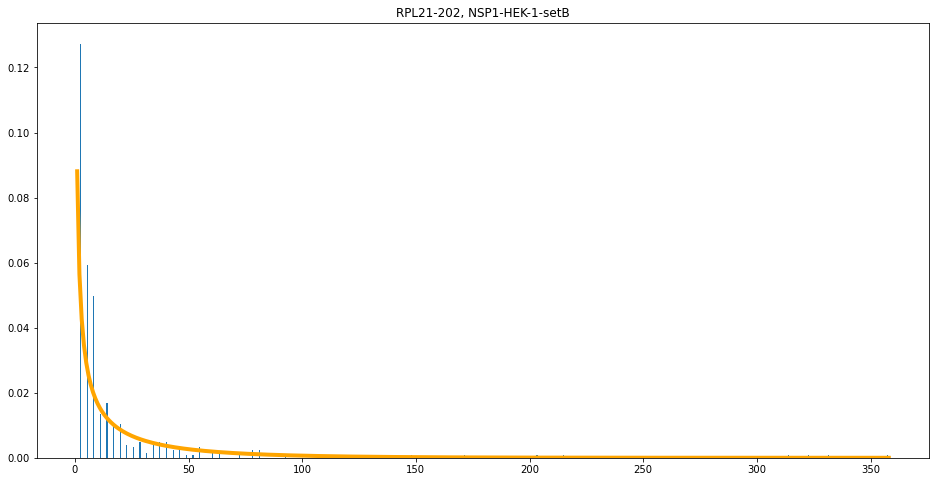

In [15]:
plt.rcParams['figure.figsize'] = [16, 8]
this_experiment = "20200717-NSP1-HEK-1-setB"

this_gene = coverages[this_experiment][0].sort_values(by = "norm_cds", ascending = False)[:1000].index[50]

plot_coverage_distribution(coverage_dict = coverages,
                               experiment   = this_experiment,
                               gene_name    = this_gene,
                               title        = "",
                               percentile   = 0,
                               threshold    = 0)

n = 0.43642654134999126, p = 0.06526368543651657
Mean: 6.250700280112045
Std: 9.786525682987882


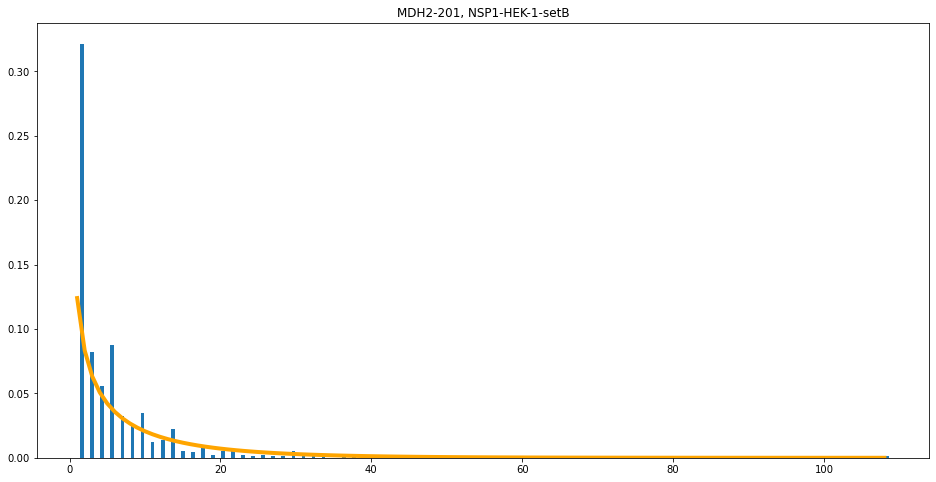

In [16]:
plt.rcParams['figure.figsize'] = [16, 8]

this_experiment = "20200717-NSP1-HEK-1-setB"

this_gene = coverages[this_experiment][0].sort_values(by = "norm_cds", ascending = False)[:1000].index[250]

plot_coverage_distribution(coverage_dict = coverages,
                               experiment   = this_experiment,
                               gene_name    = this_gene,
                               title        = "",
                               percentile   = 0,
                               threshold    = 0)

n = 0.5308692171968017, p = 0.1513330666677845
Mean: 2.9770833333333333
Std: 4.435356974704016


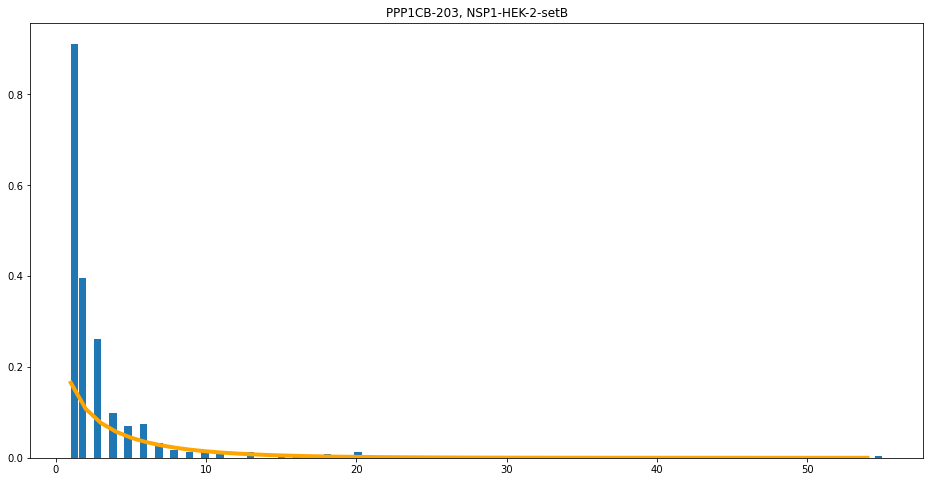

In [17]:
plt.rcParams['figure.figsize'] = [16, 8]

this_experiment = "20200717-NSP1-HEK-2-setB"

this_gene = "PPP1CB-203"

plot_coverage_distribution(coverage_dict = coverages,
                               experiment   = this_experiment,
                               gene_name    = this_gene,
                               title        = "",
                               percentile   = 0,
                               threshold    = 0)

## Calling Pause Sites

We define a pause site as follows.
First, we compute a p-value for each nucleotide position.  
Then we combine p-values, for each experiment group, using Fisher's method.
If the the combined p-value is below a pre-determined threshold (say 0.01 ), we mark this position as a pause site.

In [18]:
# Uses Fisher's method to combine the given p-values into one
stats.combine_pvalues( (0.1, 0.1, 0.1) )[1]

0.03176629677613493

In [19]:
# We simply make sure that the above function agrees with the formal definition of the Fisher's method.

chi_stat = -1 *(2*3*np.log(0.1) )

stats.chi2.sf( (chi_stat, 15) , df = 6)

array([0.0317663 , 0.02025672])

In [20]:
# Uses Fisher's method to combine the given p-values into one
stats.combine_pvalues( (0.5, 0.5, 0.5) )[1]

0.6551850130389678

In [21]:
# Uses Fisher's method to combine the given p-values into one
stats.combine_pvalues( (0.01, 0.01, 0.01) )[1]

0.00011024967654657551

In [22]:
# Uses Fisher's method to combine the given p-values into one
stats.combine_pvalues( (0.001, 0.001, 0.001) )[1]

2.3645013931132175e-07

In [23]:
def get_nb_p_values(distribution, percentile = 5):
    filtered_dist = remove_top_and_bottom_outliers(distribution, percentile)
    n, p = fit_nb(filtered_dist)
    # print(n, p)
    return  stats.nbinom.sf( distribution ,  n, p ) 

def _find_pause_sites(g, coverages, experiment_set, percentile, p_threshold):
        result    = []
        cds_start         = coverages[experiment_set[0]][0].loc[g, "cds_start"]
        cds_stop          = coverages[experiment_set[0]][0].loc[g, "cds_stop"]
        cds_len           = cds_stop - cds_start
        cds_distributions = [ coverages[e][1][g][cds_start: cds_stop] for e in experiment_set ]
        #print(cds_distributions)
        
        individual_p_vals = [get_nb_p_values( d, percentile ) for d in cds_distributions ]
        #print(individual_p_vals)
        zipped_p_vals     = [ ]
        for i in range(cds_len):
            zipped_p_vals.append( [x[i] for x in individual_p_vals] )
        #print("Thi must be zipped : ", tuple(zipped_p_vals) )
        combined_p_vals   = [ stats.combine_pvalues(p)[1] for p in zipped_p_vals ]
        
        for i in range(cds_len):
            if combined_p_vals[i] <= p_threshold:
                result.append(i)
                
        return result
    

def call_pause_sites(coverages, genes, experiment_set, p_threshold, percentile = 5, n_process = 3):
    """
    Pause sites are of the form
      gene -> position_array
    where position 
    """
    
    
    #pool_func = partial( get_nb_p_values, percentile = percentile )
    pool_func = partial(_find_pause_sites, 
                        coverages      = coverages, 
                        experiment_set = experiment_set, 
                        percentile     = percentile, 
                        p_threshold    = p_threshold)

    if __name__ == '__main__':
        with Pool(n_process) as p_pool:
                pause_locations = p_pool.map(pool_func, genes)
    
    pause_sites = dict()
    for i in range(len(genes)):
        pause_sites[genes[i]] = pause_locations[i]
    
    return pause_sites




In [24]:
# Sample Run
gene_list = []
#gene_list.append("HIST1H2BO-201")
#gene_list.append("EIF4G1-202")
gene_list.append("TCEAL9-203")
gene_list.append("EID1-201")
#gene_list.append( coverages[this_experiment][0].sort_values(by = "norm_cds", ascending = False)[:1000].index[5] )
#gene_list.append(coverages[this_experiment][0].sort_values(by = "norm_cds", ascending = False)[:1000].index[1])
#gene_list.append(coverages[this_experiment][0].sort_values(by = "norm_cds", ascending = False)[:1000].index[150])


sample_pause_sites = call_pause_sites(coverages = coverages, 
                 genes     = gene_list, 
                 experiment_set = NSP1_experiments, 
                 p_threshold = 0.01, 
                percentile = 0,
                 n_process = 2)

"""
sample_pause_sites = call_pause_sites(coverages = coverages, 
                 genes     = gene_list, 
                 experiment_set = NSP1_experiments, 
                 p_threshold = 0.0001, 
                percentile = 0,
                 n_process = 2)
"""
print(sample_pause_sites)

{'TCEAL9-203': [4, 5, 123, 156, 168, 185, 201, 209, 219, 272, 275, 281, 282], 'EID1-201': [56, 57, 299, 320, 321, 470, 471, 512, 545]}


In [25]:
stats.nbinom.sf?

In [26]:
a = [1,2]
b = [10, 20]
c = [100, 200]
tuple(zip(a,b,c))

((1, 10, 100), (2, 20, 200))

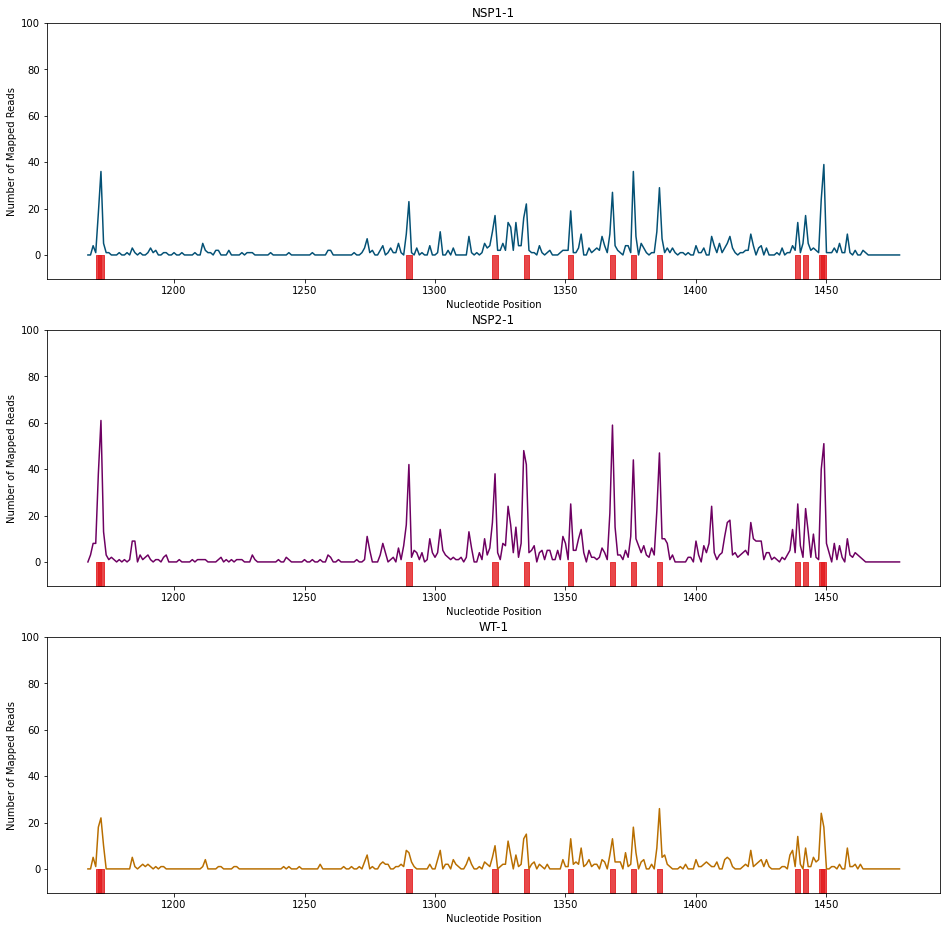

In [27]:

plt.rcParams['figure.figsize'] = [16, 16]


this_gene = "TCEAL9-203"
edge = 1

cds_start   = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_start"]
cds_stop    = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_stop"]

current_pause_sites = np.add(sample_pause_sites[this_gene], cds_start)

xrange          = tuple(range(cds_start, cds_stop))

experiments = ["20200717-NSP1-HEK-1-setB", 
               "20200717-NSP2-HEK-1-setB", 
               "20200717-WT-HEK-1-setB"]

titles = ["NSP1-1", "NSP2-1", "WT-1"]
coverage_colors = [EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"], 
                   EXPERIMENT_COLORS["20200717-NSP2-HEK-1-setB"],
                   EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]]

#plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION )
for i in range(3):
    e = experiments[i]
    
    plt.subplot(3,1,1 + i)
    plt.ylim(bottom = -10.3 , top = 100)
    plt.plot(xrange, coverages[e][1][this_gene][cds_start: cds_stop], 
             color = coverage_colors[i])
    #plt.axvspan(cds_start , cds_stop, color='gray', alpha=0.1)
    for site in current_pause_sites: 
        plt.fill_between(x     = (site - edge , site + edge), 
                         y1    = -10.3, y2 = 0, 
                         color = "#e31a1d", alpha = 0.8)
    #plt.axvspan(pause_start , pause_stop, color='red', alpha=0.2);
    plt.ylabel("Number of Mapped Reads")
    plt.xlabel("Nucleotide Position")
    plt.title(titles[i]);
    
#plt.savefig("OAZ1_cds_coverage.pdf")

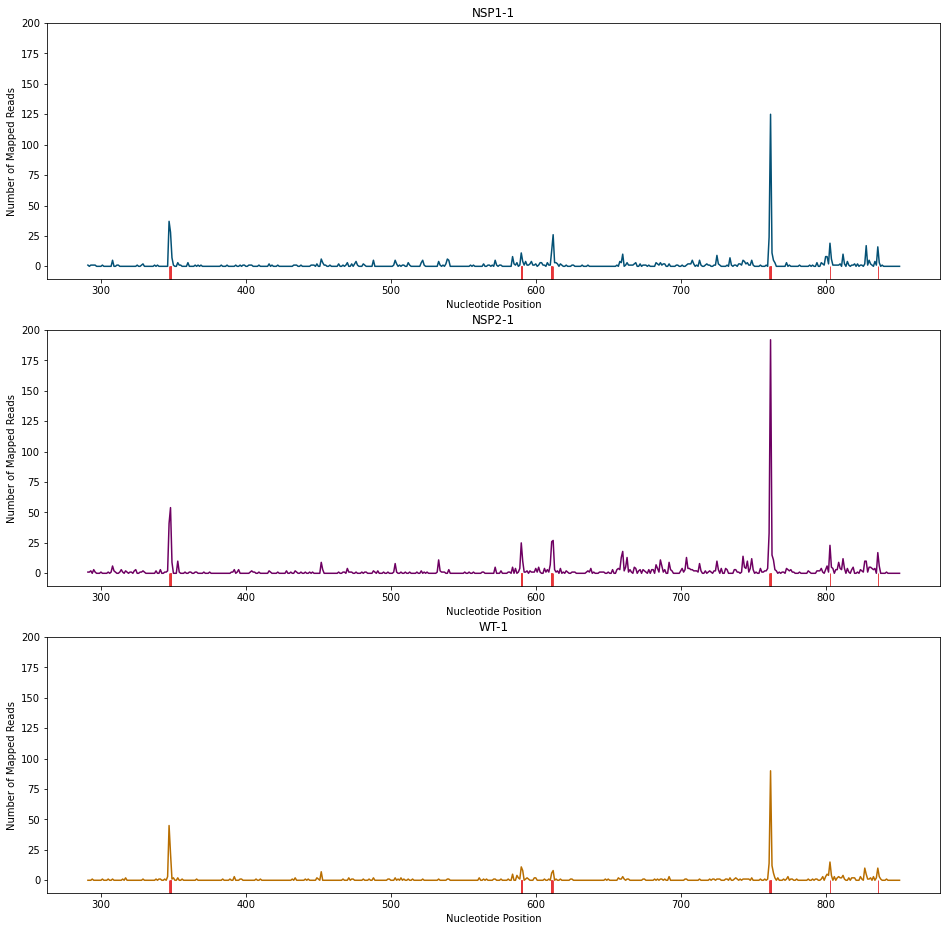

In [28]:

plt.rcParams['figure.figsize'] = [16, 16]


this_gene = "EID1-201"
edge = 0.2

cds_start   = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_start"]
cds_stop    = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_stop"]

current_pause_sites = np.add(sample_pause_sites[this_gene], cds_start)

xrange          = tuple(range(cds_start, cds_stop))

experiments = ["20200717-NSP1-HEK-1-setB", 
               "20200717-NSP2-HEK-1-setB", 
               "20200717-WT-HEK-1-setB"]

titles = ["NSP1-1", "NSP2-1", "WT-1"]
coverage_colors = [EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"], 
                   EXPERIMENT_COLORS["20200717-NSP2-HEK-1-setB"],
                   EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]]

#plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION )
for i in range(3):
    e = experiments[i]
    
    plt.subplot(3,1,1 + i)
    plt.ylim(bottom = -10.3 , top = 200)
    plt.plot(xrange, coverages[e][1][this_gene][cds_start: cds_stop], 
             color = coverage_colors[i])
    #plt.axvspan(cds_start , cds_stop, color='gray', alpha=0.1)
    for site in current_pause_sites: 
        plt.fill_between(x     = (site - edge , site + edge), 
                         y1    = -10.3, y2 = 0, 
                         color = "#e31a1d", alpha = 0.8)
    #plt.axvspan(pause_start , pause_stop, color='red', alpha=0.2);
    plt.ylabel("Number of Mapped Reads")
    plt.xlabel("Nucleotide Position")
    plt.title(titles[i]);
    
#plt.savefig("OAZ1_cds_coverage.pdf")

### Let's Find All Pause Sites

In [29]:
def find_all_pause_sites(genes, p_threshold, percentile):

    pause_sites         = dict()

    pause_sites["NSP1"] = \
            call_pause_sites(
                coverages      = coverages, 
                genes          = genes, 
                experiment_set = NSP1_experiments, 
                p_threshold    = this_p_threshold, 
                percentile     = percentile,
                n_process      = 8)

    print("NSP1 is done...")

    pause_sites["NSP2"] = \
            call_pause_sites(
                coverages      = coverages, 
                genes          = genes, 
                experiment_set = NSP2_experiments, 
                p_threshold    = this_p_threshold,
                percentile     = percentile,
                n_process      = 8)

    print("NSP2 is done...")

    pause_sites["WT"] = \
            call_pause_sites(
                coverages      = coverages, 
                genes          = genes, 
                experiment_set = WT_experiments, 
                p_threshold    = this_p_threshold,
                percentile     = percentile,
                n_process      = 8)

    print("WT is done...")
    
    return pause_sites
    

In [30]:
find_pause_sites_from_scratch = False

this_p_threshold = 0.0000001
percentile       = 0

if find_pause_sites_from_scratch:
    pause_sites = find_all_pause_sites(
                         genes       = tuple(selected_genes), 
                         p_threshold = this_p_threshold, 
                         percentile  = percentile)
    
    with open("pause_sites.pick", "wb") as pickle_out:
        pickle.dump(pause_sites, pickle_out)
    
else:
    with open("pause_sites.pick", "rb") as pickle_in:
        pause_sites = pickle.load(pickle_in)

In [31]:
#pause_sites["NSP1"]

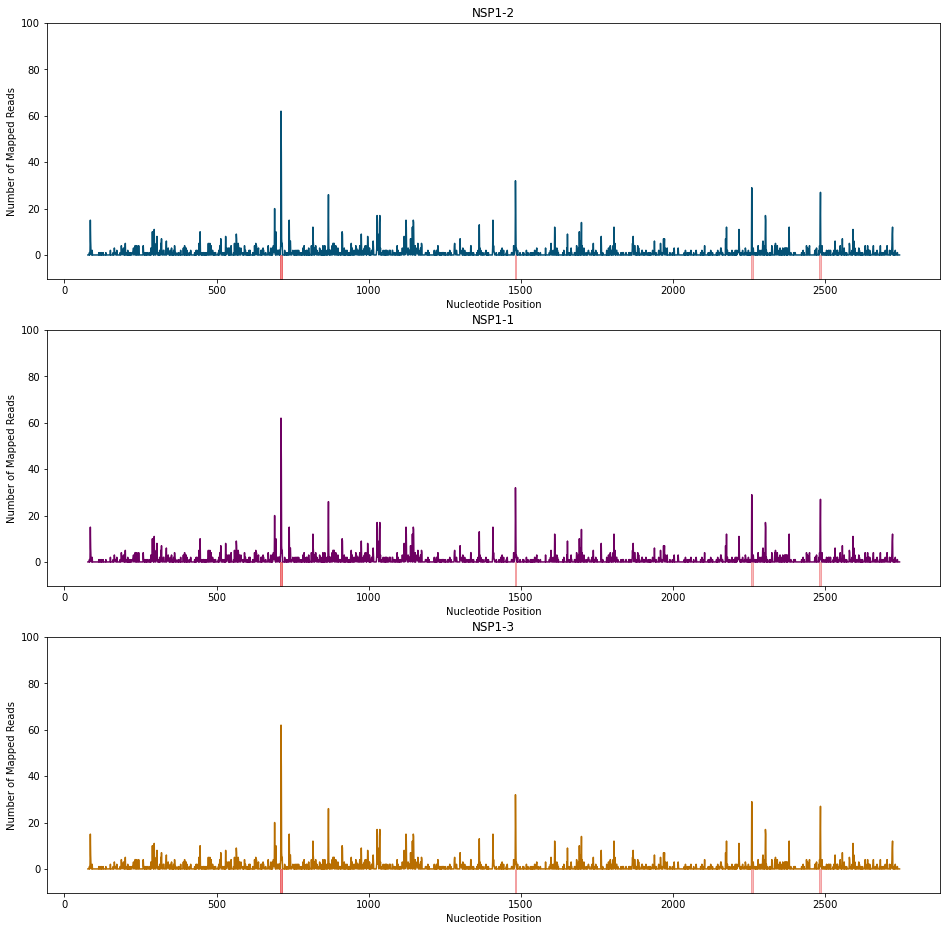

In [32]:

plt.rcParams['figure.figsize'] = [16, 16]


this_gene = "TNPO1-204"
edge = 3

cds_start   = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_start"]
cds_stop    = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_stop"]

current_pause_sites = np.add(pause_sites["NSP1"][this_gene], cds_start)

xrange          = tuple(range(cds_start, cds_stop))

experiments = ["20200717-WT-HEK-1-setB", 
               "20200717-WT-HEK-1-setB", 
               "20200717-WT-HEK-1-setB"]

titles = ["NSP1-2", "NSP1-1", "NSP1-3"]
coverage_colors = [EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"], 
                   EXPERIMENT_COLORS["20200717-NSP2-HEK-1-setB"],
                   EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]]

#plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION )
for i in range(3):
    e = experiments[i]
    
    plt.subplot(3,1,1 + i)
    plt.ylim(bottom = -10.3 , top = 100)
    plt.plot(xrange, coverages[e][1][this_gene][cds_start: cds_stop], 
             color = coverage_colors[i])
    #plt.axvspan(cds_start , cds_stop, color='gray', alpha=0.1)
    for site in current_pause_sites: 
        plt.fill_between(x     = (site - edge , site + edge), 
                         y1    = -10.3, y2 = 0, 
                         color = "#e31a1d", alpha = 0.3)
    #plt.axvspan(pause_start , pause_stop, color='red', alpha=0.2);
    plt.ylabel("Number of Mapped Reads")
    plt.xlabel("Nucleotide Position")
    plt.title(titles[i]);
    
#plt.savefig("OAZ1_cds_coverage.pdf")

In [33]:
myribo.print_info()

Ribo File Info:
---------------
Ribo File Version : 1.0
RiboPy Version    : 0.0.0
Creation Time     : 2020-09-03 10:26:28
Reference         : appris-v1
Min Read Length   : 15
Max Read Length   : 40
Metagene Radius   : 50
Left Span         : 35
Right Span        : 10

Experiments:
------------ 
Name                         Reads  Coverage  RNA-Seq  Metadata
20200717-NSP1-HEK-1-setB  12503413         *        *          
20200717-NSP1-HEK-2-setB  10390514         *        *          
20200717-NSP1-HEK-3-setB  16772718         *        *          
20200717-NSP2-HEK-1-setB  17989686         *        *          
20200717-NSP2-HEK-2-setB  16564558         *        *          
20200717-NSP2-HEK-3-setB  13487211         *        *          
20200717-WT-HEK-1-setB     8527167         *        *          
20200717-WT-HEK-2-setB    17504702         *        *          
20200717-WT-HEK-3-setB    11440519         *        *          


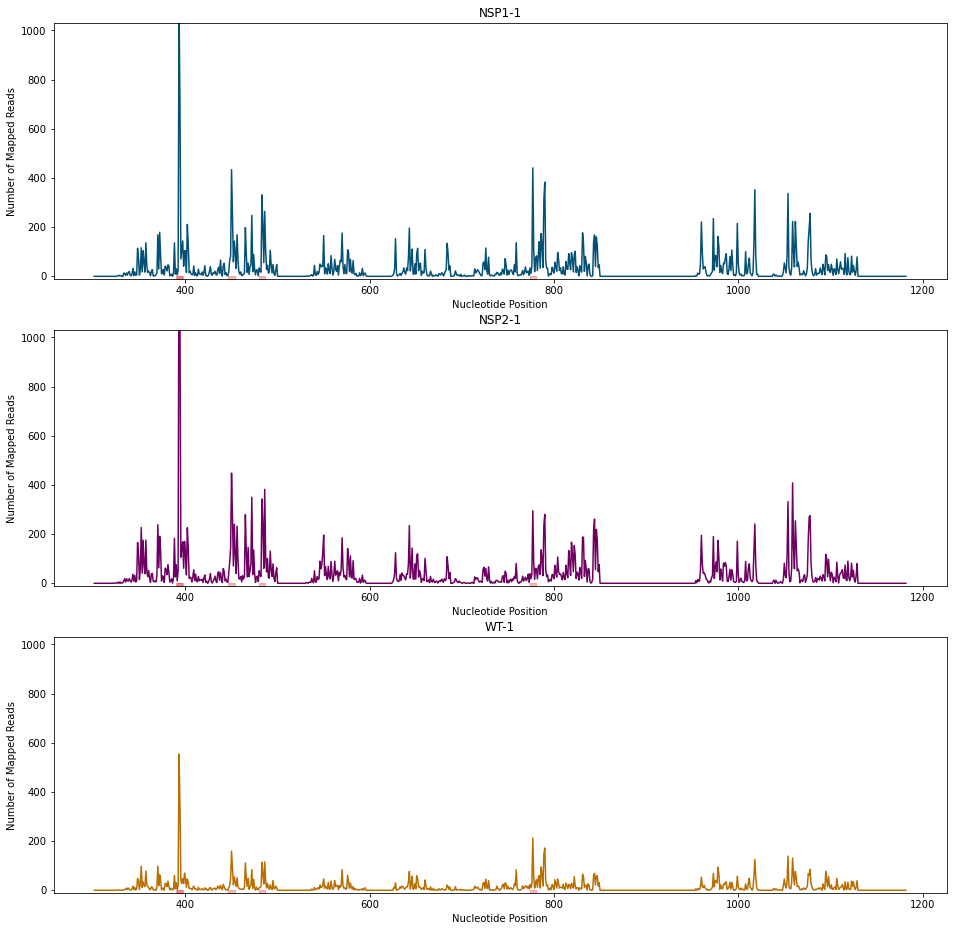

In [34]:

plt.rcParams['figure.figsize'] = [16, 16]


this_gene = "NPM1-201"
edge = 3.5

cds_start   = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_start"]
cds_stop    = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_stop"]

current_pause_sites = np.add(pause_sites["NSP1"][this_gene], cds_start)

xrange          = tuple(range(cds_start, cds_stop))

experiments = ["20200717-NSP1-HEK-1-setB", 
               "20200717-NSP2-HEK-1-setB", 
               "20200717-WT-HEK-1-setB"]

titles = ["NSP1-1", "NSP2-1", "WT-1"]
coverage_colors = [EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"], 
                   EXPERIMENT_COLORS["20200717-NSP2-HEK-1-setB"],
                   EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]]

#plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION )
for i in range(3):
    e = experiments[i]
    
    plt.subplot(3,1,1 + i)
    plt.ylim(bottom = -10.3 , top = 1030)
    plt.plot(xrange, coverages[e][1][this_gene][cds_start: cds_stop], 
             color = coverage_colors[i])
    #plt.axvspan(cds_start , cds_stop, color='gray', alpha=0.1)
    for site in current_pause_sites: 
        plt.fill_between(x     = (site - edge , site + edge), 
                         y1    = -10.3, y2 = 0, 
                         color = "#e31a1d", alpha = 0.3)
    #plt.axvspan(pause_start , pause_stop, color='red', alpha=0.2);
    plt.ylabel("Number of Mapped Reads")
    plt.xlabel("Nucleotide Position")
    plt.title(titles[i]);
    
#plt.savefig("OAZ1_cds_coverage.pdf")

## Combining Pause Sites

Here we compile pause sites into a table.
Where each row corresponds to a pause site. 
A pause site is identified by the gene name followed by its position with an underscore in between.


**Example:** A puase site at nucleotide position 122 on the gene POLR3K-201 is identified wiith 
`POLR3K-201_122`


In [35]:
def make_pause_site_sets( pause_site_dict ):
    """
    The input is of the form 
       gene -> [site1_loc, site2_loc, .....]
       
    The output is of the form
    
    gene1_loc1,.... gene5_loc7
    
    where the output is a gene
    """
    
    pause_site_list = []
    
    for g in pause_site_dict.keys():
        for i in pause_site_dict[g]:
            this_site = "{}_{}".format(g, i)
            pause_site_list.append(this_site)
            
    return set(pause_site_list)

In [36]:
NSP1_pause_site_set = make_pause_site_sets( pause_sites["NSP1"] )
NSP2_pause_site_set = make_pause_site_sets( pause_sites["NSP2"] )
WT_pause_site_set   = make_pause_site_sets( pause_sites["WT"] )

In [37]:
from matplotlib_venn import venn3

In [38]:
venn3?

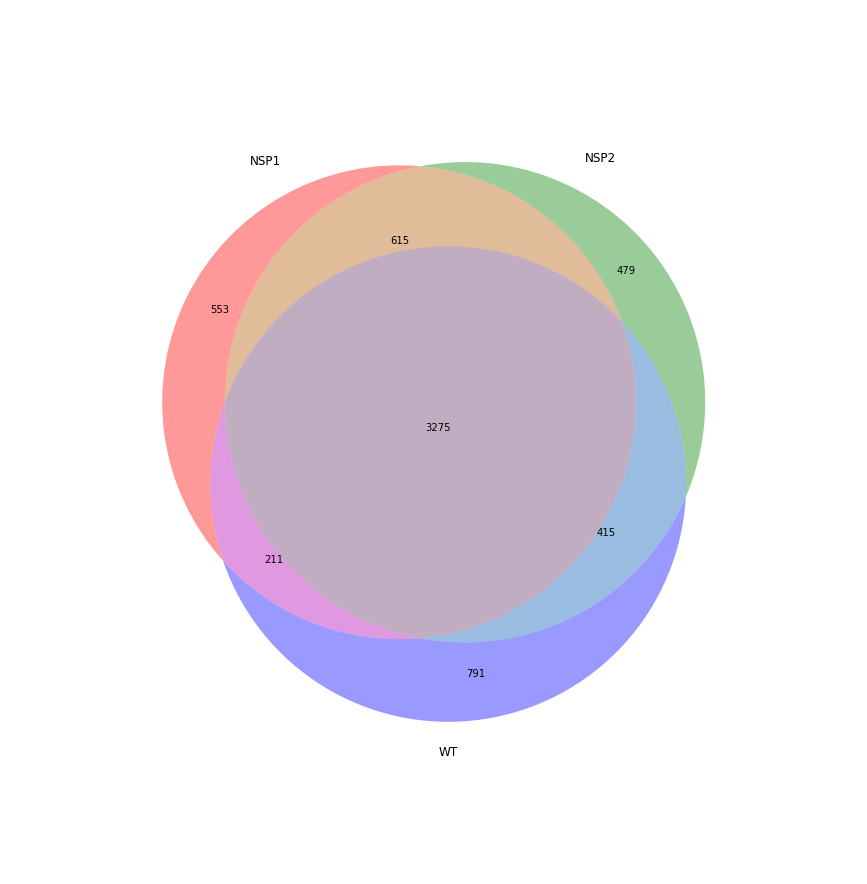

In [39]:
venn3( (NSP1_pause_site_set, NSP2_pause_site_set, WT_pause_site_set) , 
        set_labels= ("NSP1", "NSP2", "WT"), normalize_to=0.1 );

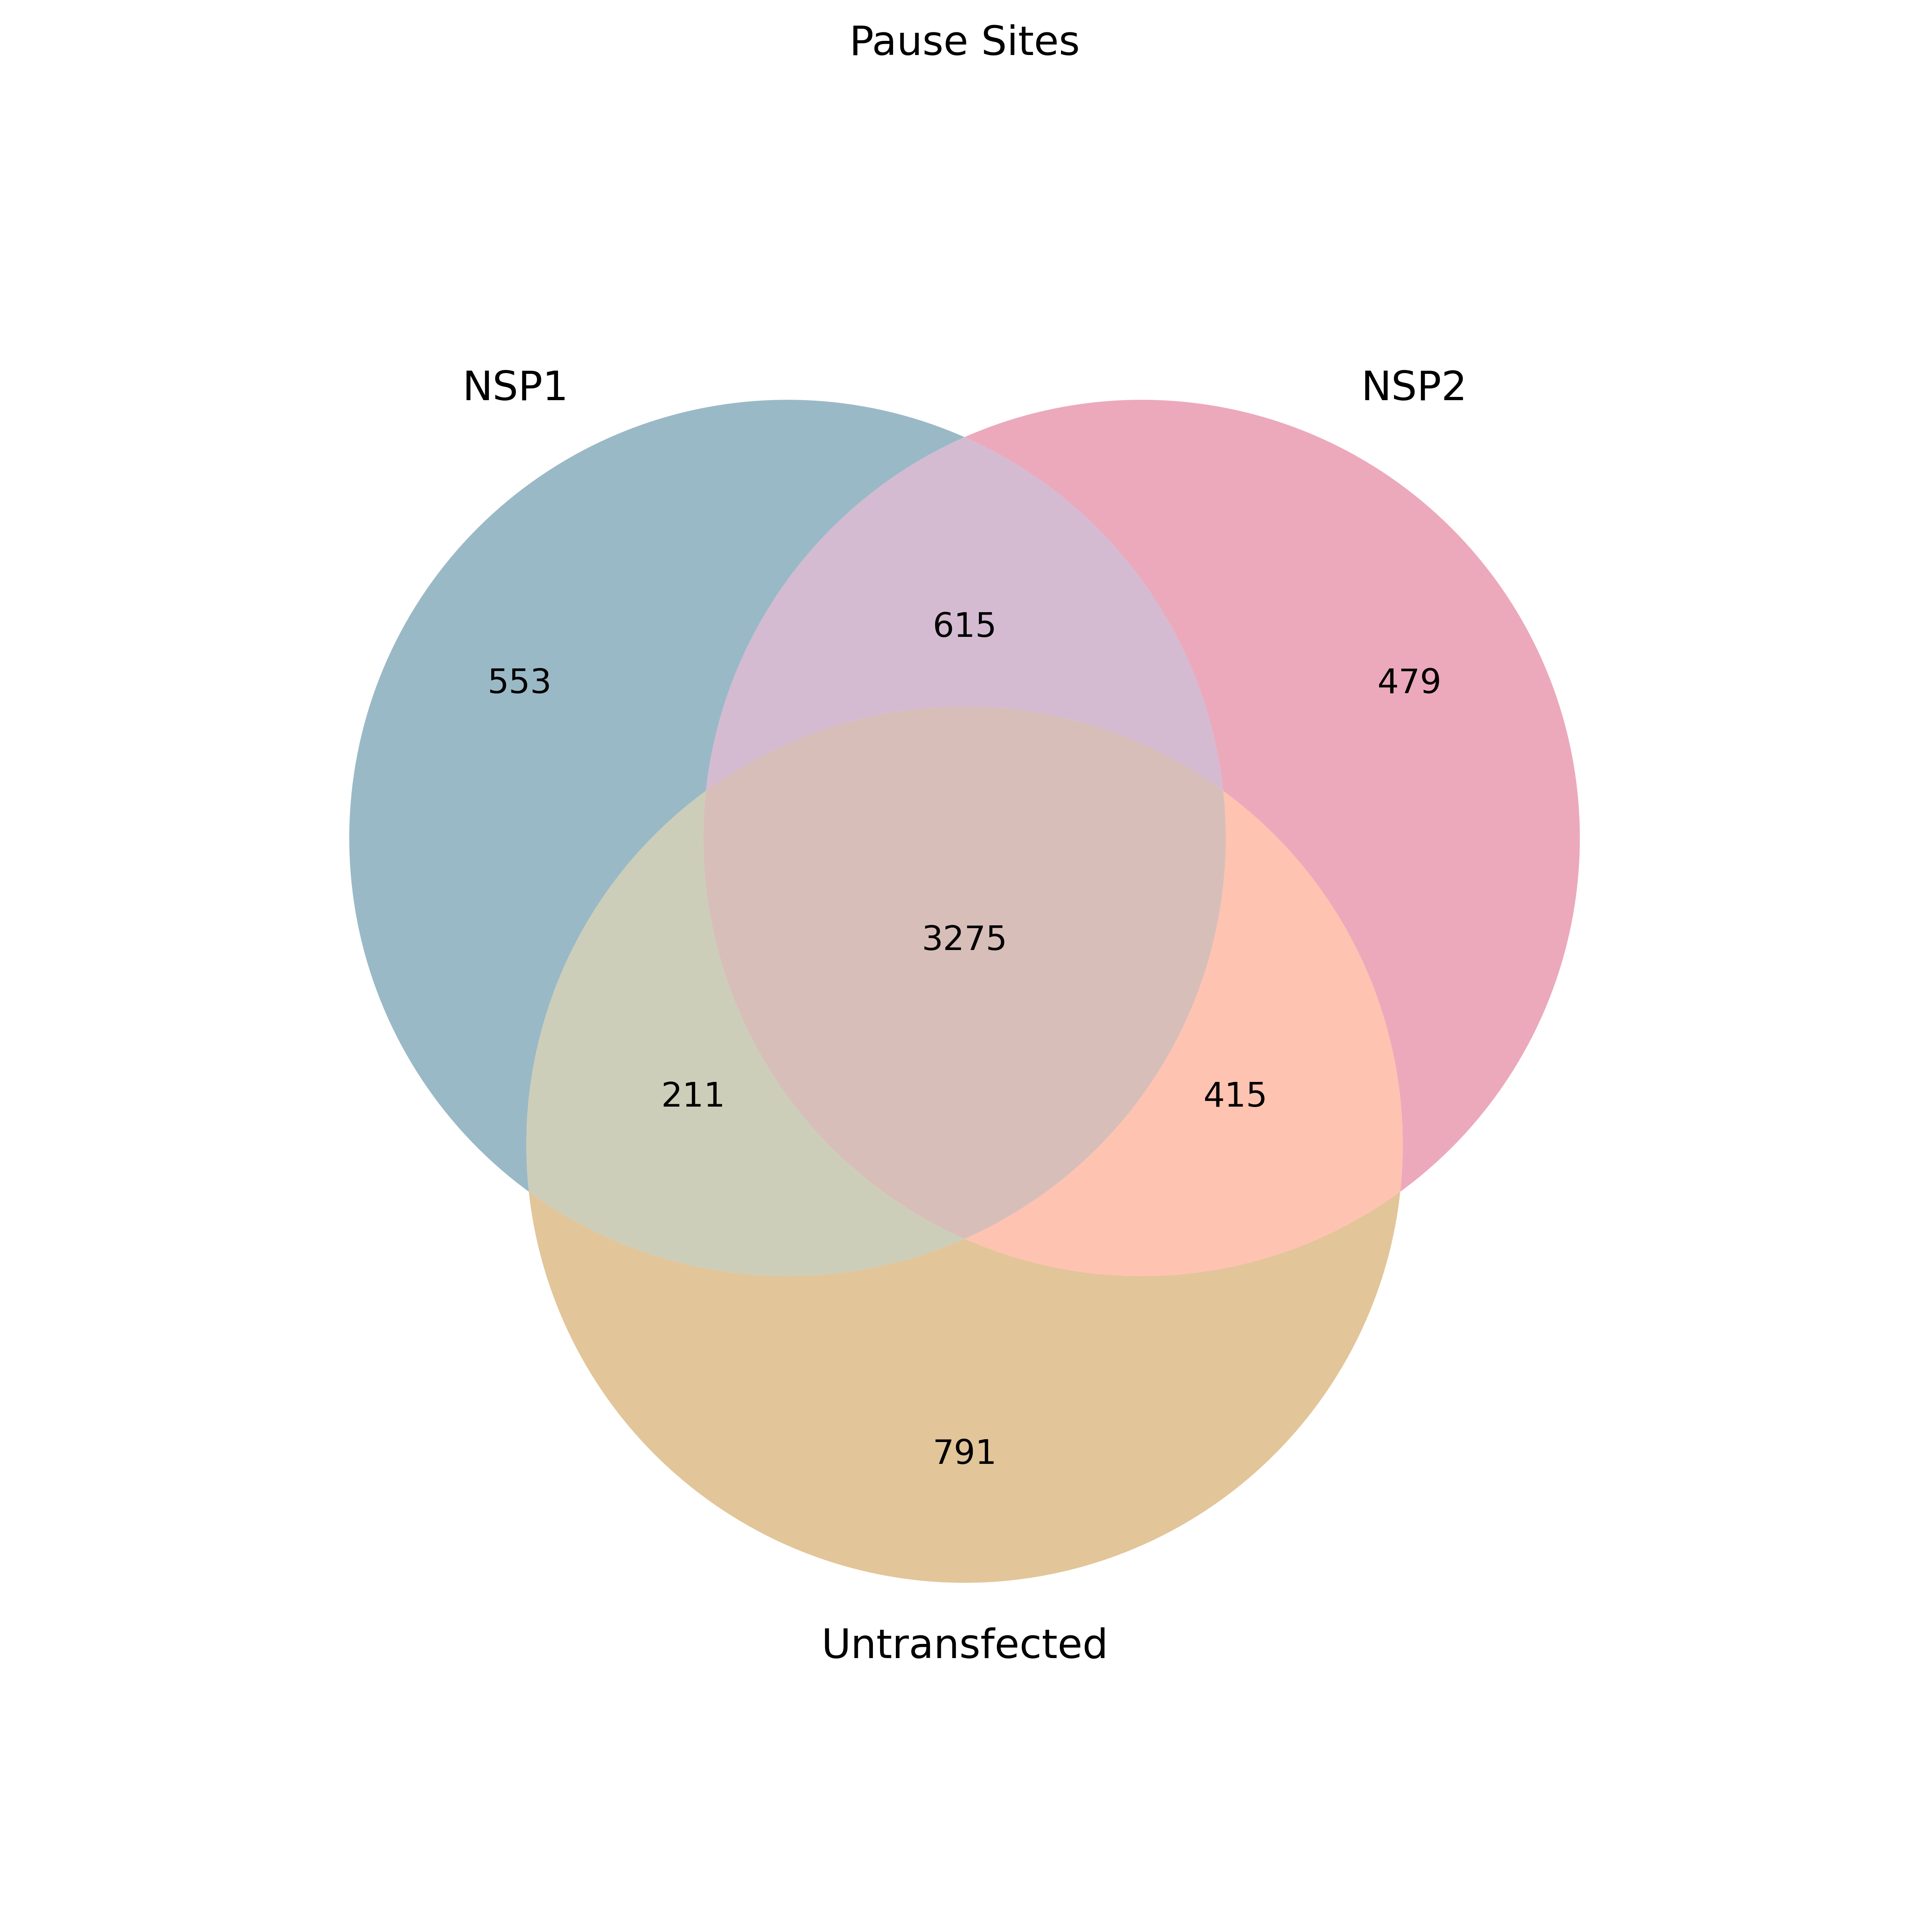

In [40]:
plt.figure( 1, (20,10),dpi = FIGURE_RESOLUTION )
#display_html("<center><b>Transcripts with CDS density $\ge 1$</b></center>", raw = True)

v = venn3( subsets=(1,1,1,1,1,1,1),
       set_labels = ("NSP1", "NSP2", "Untransfected"),
       set_colors = (EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"],
                     EXPERIMENT_COLORS["20200717-NSP2-HEK-2-setB"],
                     EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]),
      normalize_to = 0.1);


v.get_label_by_id('010').set_text('479')
v.get_label_by_id('110').set_text('615')
v.get_label_by_id('100').set_text('553')
v.get_label_by_id('001').set_text('791')
v.get_label_by_id('111').set_text('3275')
v.get_label_by_id('101').set_text('211')
v.get_label_by_id('011').set_text('415')

plt.title("Pause Sites")

plt.savefig("pause_sites_venn.pdf")

In [41]:
all_pause_sites = tuple(NSP1_pause_site_set.union( NSP2_pause_site_set, WT_pause_site_set ) )
print("There are {} pause sites in total.".format(len(all_pause_sites)))

There are 6339 pause sites in total.


In [42]:
print(all_pause_sites[:20])

('TIMM10-201_95', 'CCT6A-201_385', 'PPID-201_492', 'IRS4-201_2886', 'CDC20-202_287', 'FXR1-202_1550', 'METAP2-202_1323', 'ACAT2-201_627', 'SMC4-202_3497', 'HSD17B4-201_2193', 'STT3B-201_2411', 'AHCYL1-202_1277', 'NARS-201_1371', 'CFL1-203_383', 'HIST1H1C-201_207', 'TMCO1-202_249', 'LSM12-204_504', 'SRP54-213_104', 'HSP90AA1-201_521', 'HSP90AA1-201_758')


## Pause Site Count Table

We assemble a count table for the pause sites to study differentials.



In [43]:
def assemble_pause_site_count_table(coverages, experiments, pause_sites):
    count_dict = OrderedDict()
    
    for e in experiments:
        count_dict[e] = []
        
        for p in pause_sites:
            gene, position    = p.split("_")
            cds_start         = coverages[e][0].loc[gene, "cds_start"]
            adjusted_position = cds_start + int(position)
            pause_site_count  = coverages[e][1][gene][adjusted_position]
            
            count_dict[e].append(pause_site_count)
            
    experiment_names = tuple(map( lambda x: x[9:-11] + "-" +  x[-6], experiments ))
    result =  pd.DataFrame( count_dict, index = pause_sites )
    result.columns = experiment_names
    return result

In [44]:
pause_site_count_df = assemble_pause_site_count_table(
                             coverages   = coverages, 
                             experiments = NSP1_experiments + NSP2_experiments + WT_experiments, 
                             pause_sites = all_pause_sites)

In [45]:
pause_site_count_df

,NSP1-1,NSP1-2,NSP1-3,NSP2-1,NSP2-2,NSP2-3,WT-1,WT-2,WT-3
TIMM10-201_95,43,31,60,53,51,46,28,47,39
CCT6A-201_385,124,111,216,174,194,152,52,91,51
PPID-201_492,23,11,18,31,28,18,10,17,15
IRS4-201_2886,85,93,143,117,123,96,41,101,70
CDC20-202_287,29,16,33,45,40,38,13,28,13
...,...,...,...,...,...,...,...,...,...
CTNNB1-241_1058,37,36,79,65,86,61,38,83,67
PSIP1-203_75,58,56,63,104,124,90,95,172,133
KIF11-201_2657,17,8,12,19,27,16,12,36,23
HIST1H1C-201_101,187,185,263,312,372,369,270,642,466


A quick sanity check: Let's pick a couple of numbers in the table above and see that their counts match the coverage data.

In [46]:
sample_site_1 = pause_site_count_df.index[100]
sample_site_2 = pause_site_count_df.index[750]


table_count              = pause_site_count_df.loc[sample_site_1, "NSP2-3"]
this_gene, this_position = sample_site_1.split("_") 
cds_start                = coverages[NSP2_experiments[2]][0].loc[this_gene, "cds_start"] 
adjusted_position        = cds_start + int(this_position)
print("Value from table: {}".format(table_count) )
print( "Values centerered at pause site: {}".format(coverages[NSP2_experiments[2]][1][this_gene][adjusted_position-2 : adjusted_position + 3] ) )
#cds_start

Value from table: 197
Values centerered at pause site: [  4  28 197  30   7]


In [47]:
sample_site_1 = pause_site_count_df.index[100]
sample_site_2 = pause_site_count_df.index[750]


table_count              = pause_site_count_df.loc[sample_site_2, "NSP2-3"]
this_gene, this_position = sample_site_2.split("_") 
cds_start                = coverages[NSP2_experiments[2]][0].loc[this_gene, "cds_start"] 
adjusted_position        = cds_start + int(this_position)
print("Value from table: {}".format(table_count) )
print( "Values centerered at pause site: {}".format(coverages[NSP2_experiments[2]][1][this_gene][adjusted_position-2 : adjusted_position + 3] ) )
#cds_start

Value from table: 370
Values centerered at pause site: [ 74  82 370  99  28]


## Exporting Data to R

In [48]:
import rpy2
from rpy2 import robjects

In [49]:
from functools import partial
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

In [50]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

In [51]:
%load_ext rpy2.ipython

In [52]:
%R library(edgeR)

R[write to console]: Loading required package: limma



array(['edgeR', 'limma', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [53]:
%Rpush pause_site_count_df

In [54]:
%R pause_site_count_df

,NSP1-1,NSP1-2,NSP1-3,NSP2-1,NSP2-2,NSP2-3,WT-1,WT-2,WT-3
TIMM10-201_95,43,31,60,53,51,46,28,47,39
CCT6A-201_385,124,111,216,174,194,152,52,91,51
PPID-201_492,23,11,18,31,28,18,10,17,15
IRS4-201_2886,85,93,143,117,123,96,41,101,70
CDC20-202_287,29,16,33,45,40,38,13,28,13
...,...,...,...,...,...,...,...,...,...
CTNNB1-241_1058,37,36,79,65,86,61,38,83,67
PSIP1-203_75,58,56,63,104,124,90,95,172,133
KIF11-201_2657,17,8,12,19,27,16,12,36,23
HIST1H1C-201_101,187,185,263,312,372,369,270,642,466


In [55]:
r_all_pause_sites = robjects.StrVector(all_pause_sites)

In [56]:
%Rpush r_all_pause_sites

In [57]:
%R r_all_pause_sites

array(['TIMM10-201_95', 'CCT6A-201_385', 'PPID-201_492', ...,
       'KIF11-201_2657', 'HIST1H1C-201_101', 'SAMM50-201_669'],
      dtype='<U18')

In [58]:
%R nsp <- factor(c("NSP1","NSP1","NSP1","NSP2","NSP2","NSP2", "WT","WT","WT" )  )

[NSP1, NSP1, NSP1, NSP2, NSP2, NSP2, WT, WT, WT]
Categories (3, object): [NSP1, NSP2, WT]

In [59]:
%R  y <- DGEList(counts=pause_site_count_df,group=nsp, genes = r_all_pause_sites)

counts,[RTYPES.INTSXP]
samples,[RTYPES.VECSXP]
genes,[RTYPES.VECSXP]


In [60]:
%R y$counts

array([[ 43,  31,  60, ...,  28,  47,  39],
       [124, 111, 216, ...,  52,  91,  51],
       [ 23,  11,  18, ...,  10,  17,  15],
       ...,
       [ 17,   8,  12, ...,  12,  36,  23],
       [187, 185, 263, ..., 270, 642, 466],
       [ 34,  26,  44, ...,  25,  50,  30]], dtype=int32)

In [61]:
%R keep <- filterByExpr(y)
%R y <- y[keep,,keep.lib.sizes=FALSE]
%R y <- calcNormFactors(y, method= "TMM")
%R design <- model.matrix(~0+nsp)
%R y <- estimateDisp(y,design)

R object with classes: ('DGEList',) mapped to:
[IntSexpVe..., ListSexpV..., ListSexpV..., FloatSexp..., ..., StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
  counts: <class 'rpy2.robjects.vectors.IntMatrix'>
  R object with classes: ('matrix',) mapped to:
[43, 124, 23, 85, ..., 133, 23, 466, 30]
R object with classes: ('DGEList',) mapped to:
[IntSexpVe..., ListSexpV..., ListSexpV..., FloatSexp..., ..., StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
R object with classes: ('DGEList',) mapped to:
[IntSexpVe..., ListSexpV..., ListSexpV..., FloatSexp..., ..., StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
  design: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[1.000000, 1.000000, 1.000000, 0.000000, ..., 0.000000, 1.000000, 1.000000, 1.000000]
...
  trended.dispersion: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['locfit']
  tagwise.dispersion: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[42.498715]
  AveLogCPM: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[7.083119]
  trend.method: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.316609]

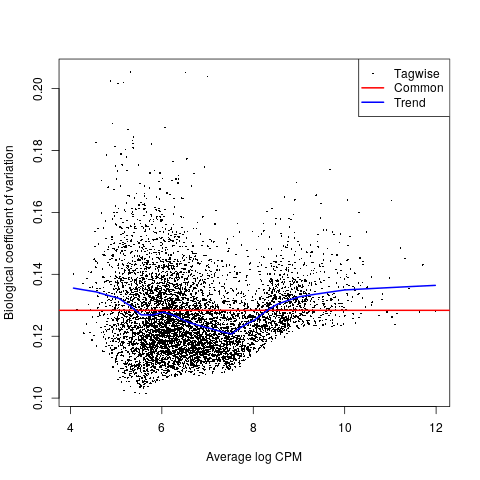

In [62]:
%R plotBCV(y, cex = 0.3)

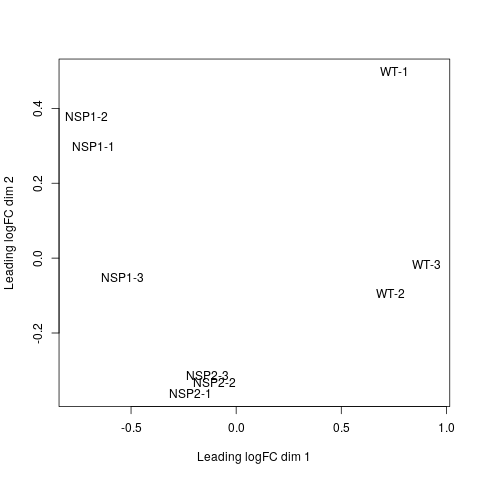

In [63]:
%R plotMDS(y, labels = c("NSP1-1", "NSP1-2", "NSP1-3", "NSP2-1", "NSP2-2", "NSP2-3", "WT-1", "WT-2", "WT-3"));

In [64]:
%R fit <- glmQLFit(y,design)

R object with classes: ('DGEGLM',) mapped to:
[FloatSexp..., FloatSexp..., FloatSexp..., StrSexpVe..., ..., FloatSexp..., FloatSexp..., ListSexpV..., ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[-9.410497, -8.203838, -10.346147, -8.529850, ..., -8.230159, -9.972836, -7.013510, -9.575925]
  fitted.values: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[44.135169, 147.778107, 17.246352, 106.633693, ..., 119.539790, 20.848540, 403.773520, 31.051528]
  deviance: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[1.083977, 3.728181, 3.907251, 5.137836, ..., 4.745567, 5.705909, 7.781370, 0.533627]
  method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['oneway']
...
  unshrunk.coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.876892, 0.921233, 0.967517, 0.952837, ..., 0.944284, 1.004647, 0.993448, 0.867172]
  df.residual: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.975186, 0.963568, 1.012174, 0.966465, ..., 0.965935, 1.012223, 0.950607, 0.977044]
R object with classes: ('DGEGLM',) mapped to:
[FloatSexp..., FloatSexp..., FloatSexp..., StrSexpVe..., ..., FloatSexp..., FloatSexp..., ListSexpV..., ListSexpV...]
R object with classes: ('DGEGLM',) mapped to:
[FloatSexp..., FloatSexp..., FloatSexp..., StrSexpVe..., ..., FloatSexp..., FloatSexp..., ListSexpV..., ListSexpV...]

In [65]:
nsp_contrast = np.array([1, -1, 0])
%Rpush nsp_contrast
%R print(nsp_contrast)
%R qlf <- glmQLFTest(fit, contrast=nsp_contrast)

[1]  1 -1  0


R object with classes: ('DGELRT',) mapped to:
[FloatSexp..., FloatSexp..., FloatSexp..., StrSexpVe..., ..., ListSexpV..., StrSexpVe..., IntSexpVe..., FloatSexp...]
  coefficients: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[-9.410497, -8.203838, -10.346147, -8.529850, ..., -8.230159, -9.972836, -7.013510, -9.575925]
  fitted.values: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[44.135169, 147.778107, 17.246352, 106.633693, ..., 119.539790, 20.848540, 403.773520, 31.051528]
  deviance: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[1.083977, 3.728181, 3.907251, 5.137836, ..., 4.745567, 5.705909, 7.781370, 0.533627]
  method: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['oneway']
...
R object with classes: ('DGELRT',) mapped to:
[FloatSexp..., FloatSexp..., FloatSexp..., StrSexpVe..., ..., ListSexpV..., StrSexpVe..., IntSexpVe..., FloatSexp...]
  design: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['1*nspNSP1 -1*nspNSP2']
  offset: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[1, 1, 1, 1, ..., 1, 1, 1, 1]
  dispersion: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[48.498715, 48.498715, 48.498715, 48.498715, ..., 48.498715, 48.498715, 48.498715, 48.498715]

In [66]:
%R topTags(qlf, sort.by = "logFC", p.value = 0.05)

table,[RTYPES.VECSXP]
adjust.method,[RTYPES.STRSXP]
comparison,[RTYPES.STRSXP]
test,[RTYPES.STRSXP]


In [67]:
%R print(summary(decideTests(qlf, p.value = 0.05, adjust.method = "fdr")) )

       1*nspNSP1 -1*nspNSP2
Down                    117
NotSig                 5937
Up                      285


array([[ 117.],
       [5937.],
       [ 285.]])

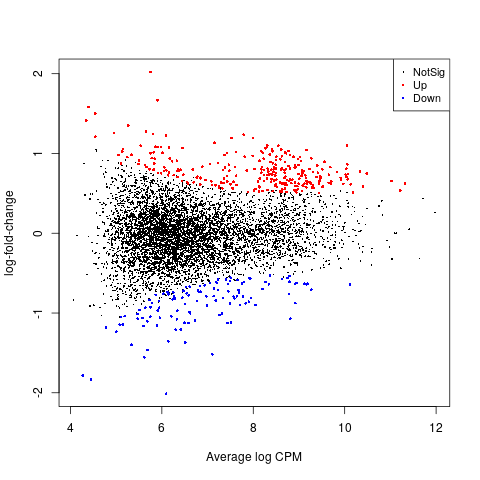

In [68]:
%R plotMD(qlf, p.value = 0.05, hl.cex = 0.5, main = "")

In [69]:
%R fold_change_table <- topTags(qlf, n = 6339, sort.by = "logFC", p.value = 0.05)$table

,genes,logFC,logCPM,F,PValue,FDR
EIF4B-201_1818,EIF4B-201_1818,2.022716,5.753486,55.509626,1.416539e-09,0.000009
DDIT4-201_249,DDIT4-201_249,-2.011342,6.094454,40.108394,7.449126e-08,0.000047
ZCCHC12-201_1163,ZCCHC12-201_1163,-1.831066,4.452561,19.570685,5.473081e-05,0.003007
ZCCHC12-201_1028,ZCCHC12-201_1028,-1.783539,4.271705,17.844760,1.050733e-04,0.004500
SLC25A6-201_212,SLC25A6-201_212,1.668413,5.905327,50.140121,5.239543e-09,0.000012
...,...,...,...,...,...,...
NCL-201_1725,NCL-201_1725,0.517241,8.727479,10.229644,2.435700e-03,0.042652
DHX9-201_2895,DHX9-201_2895,0.515521,7.887204,9.886110,2.841456e-03,0.046347
ACTG1-210_576,ACTG1-210_576,0.511510,8.943909,9.680401,3.118003e-03,0.049413
RPL37-201_221,RPL37-201_221,0.508016,10.180991,11.096290,1.660265e-03,0.032857


In [70]:
%Rpull fold_change_table

In [71]:
fold_change_table

<rpy2.rinterface.ListSexpVector object at 0x7fdcd3001e88> [RTYPES.VECSXP]

In [72]:
with localconverter(ro.default_converter + pandas2ri.converter):
    differential_pause_site_df = ro.conversion.rpy2py(fold_change_table)

differential_pause_site_df

,genes,logFC,logCPM,F,PValue,FDR
EIF4B-201_1818,EIF4B-201_1818,2.022716,5.753486,55.509626,1.416539e-09,0.000009
DDIT4-201_249,DDIT4-201_249,-2.011342,6.094454,40.108394,7.449126e-08,0.000047
ZCCHC12-201_1163,ZCCHC12-201_1163,-1.831066,4.452561,19.570685,5.473081e-05,0.003007
ZCCHC12-201_1028,ZCCHC12-201_1028,-1.783539,4.271705,17.844760,1.050733e-04,0.004500
SLC25A6-201_212,SLC25A6-201_212,1.668413,5.905327,50.140121,5.239543e-09,0.000012
...,...,...,...,...,...,...
NCL-201_1725,NCL-201_1725,0.517241,8.727479,10.229644,2.435700e-03,0.042652
DHX9-201_2895,DHX9-201_2895,0.515521,7.887204,9.886110,2.841456e-03,0.046347
ACTG1-210_576,ACTG1-210_576,0.511510,8.943909,9.680401,3.118003e-03,0.049413
RPL37-201_221,RPL37-201_221,0.508016,10.180991,11.096290,1.660265e-03,0.032857


## Differential CDS

In [73]:
all_cds_counts = \
    myribo.get_region_counts(
                         region_name    = "CDS", 
                         sum_lengths    = True, 
                         sum_references = False, 
                         range_lower    = 28, 
                         range_upper    = 35, 
                         experiments    = NSP1_experiments + NSP2_experiments + WT_experiments , 
                         alias          = rename)

In [74]:
#selected_cds_counts = all_cds_counts.loc[selected_genes]
# Monkey patch
selected_cds_counts = all_cds_counts

In [75]:
selected_cds_counts.columns = ("NSP1-1", "NSP1-2", "NSP1-3", "NSP2-1", "NSP2-2", "NSP2-3", "WT-1", "WT-2", "WT-3")


In [76]:
# Dont forget the dtype conversion
# Otherwise, it won't be exported to R

#cds_counts_dict = { c: selected_cds_counts[c] for c in selected_cds_counts.columns }
#cds_counts      = pd.DataFrame(cds_counts_dict, index = selected_genes, dtype= np.int32)

# Monkley patch
cds_counts_dict = { c: selected_cds_counts[c] for c in selected_cds_counts.columns }
cds_counts      = pd.DataFrame(cds_counts_dict, index = all_cds_counts.index, dtype= np.int32)


In [77]:
# r_selected_genes = np.array(tuple(selected_genes) )
r_selected_genes =  cds_counts.index
%Rpush cds_counts
%Rpush r_selected_genes

In [78]:
#%R  y_cds <- DGEList(counts=cds_counts,group=nsp, genes = r_selected_genes)
%R  y_cds <- DGEList(counts=cds_counts,group=nsp, genes = r_selected_genes)

counts,[RTYPES.INTSXP]
samples,[RTYPES.VECSXP]
genes,[RTYPES.VECSXP]


In [79]:
%R keep <- filterByExpr(y_cds)
%R y_cds <- y_cds[keep,,keep.lib.sizes=FALSE]
%R y_cds <- calcNormFactors(y_cds, method= "TMM")
%R design_cds <- model.matrix(~0+nsp)
%R y_cds <- estimateDisp(y_cds,design_cds)

R object with classes: ('DGEList',) mapped to:
[IntSexpVe..., ListSexpV..., ListSexpV..., FloatSexp..., ..., StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
  counts: <class 'rpy2.robjects.vectors.IntMatrix'>
  R object with classes: ('matrix',) mapped to:
[185, 2,450, 58, 184, ..., 180, 1,796, 308, 1,965]
R object with classes: ('DGEList',) mapped to:
[IntSexpVe..., ListSexpV..., ListSexpV..., FloatSexp..., ..., StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
R object with classes: ('DGEList',) mapped to:
[IntSexpVe..., ListSexpV..., ListSexpV..., FloatSexp..., ..., StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
  design: <class 'rpy2.robjects.vectors.FloatMatrix'>
  R object with classes: ('matrix',) mapped to:
[1.000000, 1.000000, 1.000000, 0.000000, ..., 0.000000, 1.000000, 1.000000, 1.000000]
...
  trended.dispersion: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['locfit']
  tagwise.dispersion: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[20.145511]
  AveLogCPM: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[3.357585]
  trend.method: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.298445]

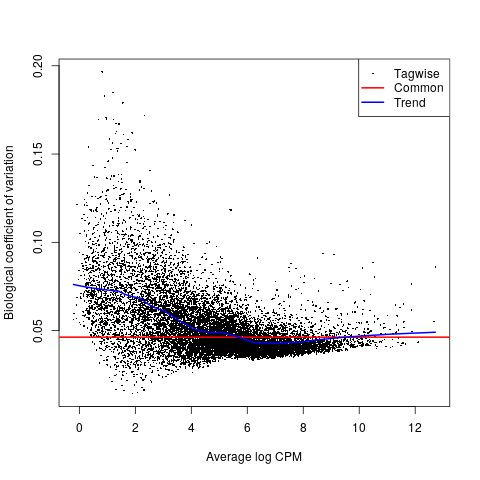

In [80]:
%R plotBCV(y_cds, cex = 0.3)

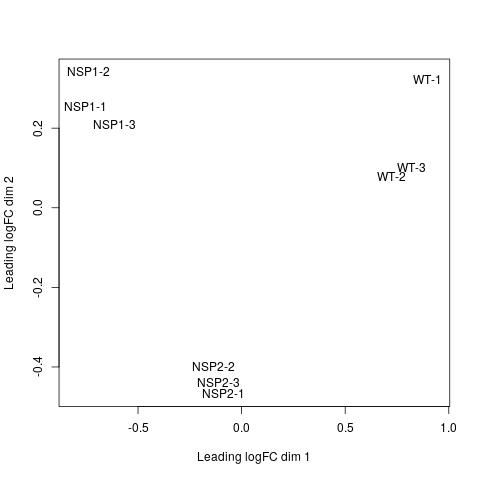

In [81]:
%R plotMDS(y_cds, labels = c("NSP1-1", "NSP1-2", "NSP1-3", "NSP2-1", "NSP2-2", "NSP2-3", "WT-1", "WT-2", "WT-3"));

In [82]:
%R fit_cds <- glmQLFit(y_cds,design_cds);

In [83]:
nsp_contrast = np.array([1, -1, 0])
%Rpush nsp_contrast
%R print(nsp_contrast)
%R qlf_cds <- glmQLFTest(fit_cds, contrast=nsp_contrast);

[1]  1 -1  0


In [84]:
%R topTags(qlf_cds, sort.by = "logFC", p.value = 0.05)$table

,genes,logFC,logCPM,F,PValue,FDR
ANKRD1-201,ANKRD1-201,-3.339547,0.183205,31.022073,7.381063e-06,1.498117e-04
MYO1A-203,MYO1A-203,2.973702,1.309982,107.248445,9.564758e-11,2.578655e-08
EGR1-201,EGR1-201,-2.918764,3.611836,422.244993,1.164168e-17,6.975694e-14
ETV5-201,ETV5-201,-2.906349,2.707048,194.573450,1.268412e-13,1.169281e-10
FAXDC2-201,FAXDC2-201,-2.875823,0.973797,18.214869,2.295646e-04,2.054595e-03
CHAC1-204,CHAC1-204,-2.661116,4.988026,426.021488,1.043025e-17,6.975694e-14
ETV4-201,ETV4-201,-2.655344,0.150340,32.079577,5.769477e-06,1.245791e-04
AC022506.1-201,AC022506.1-201,-2.512935,0.279752,12.798482,1.384060e-03,8.130677e-03
UBA7-201,UBA7-201,2.330625,0.235668,36.019242,2.397267e-06,6.384189e-05
INHBE-201,INHBE-201,-2.308681,2.007801,46.736048,2.864483e-07,1.187819e-05


In [85]:
%R print(summary(decideTests(qlf_cds, p.value = 0.05, adjust.method = "fdr")) )

       1*nspNSP1 -1*nspNSP2
Down                   1722
NotSig                 8358
Up                     1904


array([[1722.],
       [8358.],
       [1904.]])

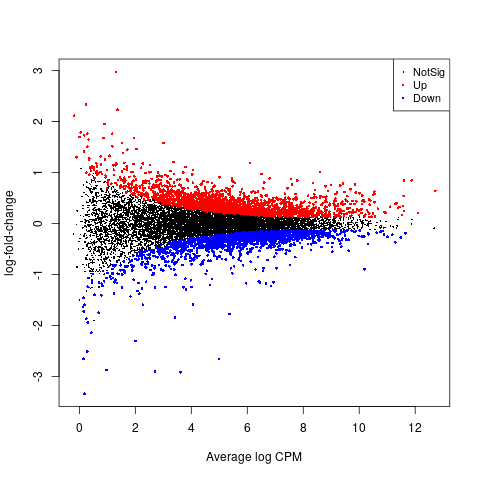

In [86]:
%R plotMD(qlf_cds, p.value = 0.05, hl.cex = 0.5, main = "")

In [87]:
%R fold_change_table_cds <- topTags(qlf_cds, n = 4000, sort.by = "logFC", p.value = 0.05)$table

,genes,logFC,logCPM,F,PValue,FDR
ANKRD1-201,ANKRD1-201,-3.339547,0.183205,31.022073,7.381063e-06,1.498117e-04
MYO1A-203,MYO1A-203,2.973702,1.309982,107.248445,9.564758e-11,2.578655e-08
EGR1-201,EGR1-201,-2.918764,3.611836,422.244993,1.164168e-17,6.975694e-14
ETV5-201,ETV5-201,-2.906349,2.707048,194.573450,1.268412e-13,1.169281e-10
FAXDC2-201,FAXDC2-201,-2.875823,0.973797,18.214869,2.295646e-04,2.054595e-03
...,...,...,...,...,...,...
AP1G1-201,AP1G1-201,0.129053,7.817504,6.931472,1.403093e-02,4.743206e-02
USP33-204,USP33-204,-0.127761,8.239435,6.846974,1.456294e-02,4.868065e-02
GCN1-201,GCN1-201,0.127211,8.797173,6.983228,1.371562e-02,4.662923e-02
DHX15-201,DHX15-201,0.126193,9.327646,7.026872,1.345578e-02,4.596751e-02


In [88]:
%Rpull fold_change_table_cds

In [89]:
with localconverter(ro.default_converter + pandas2ri.converter):
    differential_cds_df = ro.conversion.rpy2py(fold_change_table_cds)

differential_cds_df

,genes,logFC,logCPM,F,PValue,FDR
ANKRD1-201,ANKRD1-201,-3.339547,0.183205,31.022073,7.381063e-06,1.498117e-04
MYO1A-203,MYO1A-203,2.973702,1.309982,107.248445,9.564758e-11,2.578655e-08
EGR1-201,EGR1-201,-2.918764,3.611836,422.244993,1.164168e-17,6.975694e-14
ETV5-201,ETV5-201,-2.906349,2.707048,194.573450,1.268412e-13,1.169281e-10
FAXDC2-201,FAXDC2-201,-2.875823,0.973797,18.214869,2.295646e-04,2.054595e-03
...,...,...,...,...,...,...
AP1G1-201,AP1G1-201,0.129053,7.817504,6.931472,1.403093e-02,4.743206e-02
USP33-204,USP33-204,-0.127761,8.239435,6.846974,1.456294e-02,4.868065e-02
GCN1-201,GCN1-201,0.127211,8.797173,6.983228,1.371562e-02,4.662923e-02
DHX15-201,DHX15-201,0.126193,9.327646,7.026872,1.345578e-02,4.596751e-02


In [90]:
differential_cds_df.loc["DDIT4-201"]

genes       DDIT4-201
logFC        -1.15318
logCPM        6.93767
F             185.238
PValue    2.23767e-13
FDR       1.78775e-10
Name: DDIT4-201, dtype: object

In [91]:
differential_pause_site_df

,genes,logFC,logCPM,F,PValue,FDR
EIF4B-201_1818,EIF4B-201_1818,2.022716,5.753486,55.509626,1.416539e-09,0.000009
DDIT4-201_249,DDIT4-201_249,-2.011342,6.094454,40.108394,7.449126e-08,0.000047
ZCCHC12-201_1163,ZCCHC12-201_1163,-1.831066,4.452561,19.570685,5.473081e-05,0.003007
ZCCHC12-201_1028,ZCCHC12-201_1028,-1.783539,4.271705,17.844760,1.050733e-04,0.004500
SLC25A6-201_212,SLC25A6-201_212,1.668413,5.905327,50.140121,5.239543e-09,0.000012
...,...,...,...,...,...,...
NCL-201_1725,NCL-201_1725,0.517241,8.727479,10.229644,2.435700e-03,0.042652
DHX9-201_2895,DHX9-201_2895,0.515521,7.887204,9.886110,2.841456e-03,0.046347
ACTG1-210_576,ACTG1-210_576,0.511510,8.943909,9.680401,3.118003e-03,0.049413
RPL37-201_221,RPL37-201_221,0.508016,10.180991,11.096290,1.660265e-03,0.032857


In [92]:
median_logFC = np.median(differential_pause_site_df["logFC"])
print("Median log fold change is {:.4f}".format(float(median_logFC)))

Median log fold change is 0.6561


## A List of Fairly Confident Differential Pause Sites (Level 1)

First we find pause sites whose genes are not on our differential translation list.
So the following list of translation sites have the following properties:  

   1) The pause site is significantly higher ( lower ) with decent confidence.   
   2) The gene of the pause site is **not** significantly different in terms of translation.     
   
As an immediate corrollary of 1 and 2 we can say that 
the difference in the pause site is not coming from the difference of the trasnlation of the gene.

In [94]:
interesting_counter          = 0
confident_pause_sites        = []
confident_pause_site_indices = [] 

for pause_site in differential_pause_site_df.index:
    gene, position = pause_site.split("_")
    this_ps_index = False
    
    if gene not in differential_cds_df.index:
        this_ps_index        = True
        interesting_counter += 1

        this_logFC = differential_pause_site_df.loc[pause_site,"logFC"]
        confident_pause_sites.append( (pause_site, this_logFC) )
        
    confident_pause_site_indices.append(this_ps_index)
        
print( "There are {} pause sites not from cds diff.".format(interesting_counter) )

There are 39 pause sites not from cds diff.


In [95]:
#with open("level_1_diff_pause_sites.pick", "wb") as pickle_out:
#        pickle.dump(confident_pause_sites, pickle_out)

In [96]:

confident_pause_sites_df = differential_pause_site_df.loc[confident_pause_site_indices]
confident_pause_sites_df

,genes,logFC,logCPM,F,PValue,FDR
COX7A2L-202_230,COX7A2L-202_230,1.583211,4.398079,14.512678,0.000392,0.012072
SFT2D2-201_395,SFT2D2-201_395,1.414209,4.345828,12.562107,0.000883,0.021038
EPRS-201_110,EPRS-201_110,-1.369131,6.511964,26.963303,0.000004,0.000574
NUP205-201_3261,NUP205-201_3261,1.350562,5.267839,22.790612,0.000017,0.001383
GRINA-201_866,GRINA-201_866,1.277528,5.650977,24.540737,0.000009,0.000977
TMEM41B-204_564,TMEM41B-204_564,-1.235015,5.002770,11.766159,0.001241,0.026396
WDR61-201_587,WDR61-201_587,1.211650,4.545439,11.246797,0.001555,0.031262
PPID-201_1046,PPID-201_1046,-1.146325,5.079207,12.468718,0.000919,0.021485
RPA1-201_879,RPA1-201_879,1.054510,5.147926,11.918043,0.001162,0.025407
MARCKS-201_452,MARCKS-201_452,-0.971585,6.339494,14.052129,0.000474,0.013984


## A List of Somewhat Confident Differential Pause Sites (Level 2)

As the next step, we look at the pause sites whose genes are in our differential translation list.
For the log fold change, if the difference between the pause site and the gene of the pause site are above a threshold, the differential of this pause site is probably genuine. 
In other words, the significant difference (between NSP1 and NSP2) at the pause site is **not** coming from the difference of the translation (between NSP1 and NSP2) but it is coming from the particular difference **at the pause site**, between NSP1 and NSP2.

In [99]:
level_2_counter             = 0
threshold_differences       = []
differential_level2_indices = []
abs_differences_level2     = []


for pause_site in differential_pause_site_df.index:
    gene, position = pause_site.split("_")
    position       = int(position)
    this_ps_index  = False
    
    if gene in differential_cds_df.index:
        level_2_counter += 1
        
        log_fc_cds        = differential_cds_df.loc[gene, "logFC"]
        log_fc_pause_site = differential_pause_site_df.loc[pause_site, "logFC"]
        log_fc_difference = abs( log_fc_cds - log_fc_pause_site)
        threshold_differences.append(log_fc_difference)
        if log_fc_difference > 0.8:
            print(differential_pause_site_df.loc[pause_site,:])
            print("LogFC Difference: {}".format(log_fc_difference))
            print("----------------------")
            this_ps_index  = True
            abs_differences_level2.append(log_fc_difference)
            confident_pause_sites.append( (pause_site, log_fc_pause_site) )
    differential_level2_indices.append(this_ps_index)
        
print(level_2_counter)

genes     EIF4B-201_1818
logFC            2.02272
logCPM           5.75349
F                55.5096
PValue       1.41654e-09
FDR          8.97944e-06
Name: EIF4B-201_1818, dtype: object
LogFC Difference: 1.0090079950015627
----------------------
genes     DDIT4-201_249
logFC          -2.01134
logCPM          6.09445
F               40.1084
PValue      7.44913e-08
FDR           4.722e-05
Name: DDIT4-201_249, dtype: object
LogFC Difference: 0.8581652968520723
----------------------
genes     SMARCB1-213_731
logFC             1.50107
logCPM            4.54224
F                  13.222
PValue        0.000668545
FDR             0.0175847
Name: SMARCB1-213_731, dtype: object
LogFC Difference: 1.2413410191895982
----------------------
genes     DPY30-202_275
logFC           -1.4653
logCPM          5.68308
F               24.0543
PValue      1.09349e-05
FDR          0.00106641
Name: DPY30-202_275, dtype: object
LogFC Difference: 1.1978544302832106
----------------------
genes     PPA2-201_185


In [100]:
confident_pause_sites_level2_df = differential_pause_site_df.loc[differential_level2_indices]
confident_pause_sites_level2_df["abs_logFC_diff"] = abs_differences_level2

threshold_differences.sort()
threshold_differences = np.array(threshold_differences)
cons_diff_pause_sites = threshold_differences[threshold_differences > 0.8]
print(len(cons_diff_pause_sites))
cons_diff_pause_sites

16


/home/hakan/miniconda3/envs/ribopy/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([0.84600373, 0.85025698, 0.85330886, 0.8581653 , 0.86997885,
       0.87616254, 0.90190306, 0.90574091, 1.009008  , 1.04361173,
       1.07506451, 1.10851377, 1.19785443, 1.24134102, 1.29219571,
       1.44315124])

In [101]:

confident_pause_sites_level2_df

,genes,logFC,logCPM,F,PValue,FDR,abs_logFC_diff
EIF4B-201_1818,EIF4B-201_1818,2.022716,5.753486,55.509626,1.416539e-09,0.000009,1.009008
DDIT4-201_249,DDIT4-201_249,-2.011342,6.094454,40.108394,7.449126e-08,0.000047,0.858165
SMARCB1-213_731,SMARCB1-213_731,1.501074,4.542239,13.222041,6.685450e-04,0.017585,1.241341
DPY30-202_275,DPY30-202_275,-1.465298,5.683076,24.054286,1.093494e-05,0.001066,1.197854
PPA2-201_185,PPA2-201_185,-1.355387,6.143352,25.629744,6.373490e-06,0.000792,1.108514
ADSS-201_600,ADSS-201_600,1.255770,4.957476,13.194241,6.763692e-04,0.017606,1.043612
ARF1-214_336,ARF1-214_336,1.227031,6.092086,23.849780,1.173974e-05,0.001093,0.905741
CTSL-203_848,CTSL-203_848,-1.162603,5.600538,16.806637,1.570420e-04,0.005890,0.850257
AHCYL1-202_1148,AHCYL1-202_1148,-1.144732,5.144528,12.696091,8.341077e-04,0.020336,0.876163
PRKDC-201_485,PRKDC-201_485,-1.093235,6.725329,21.819735,2.405210e-05,0.001733,0.901903


Text(0.5, 1.0, 'Distribu')

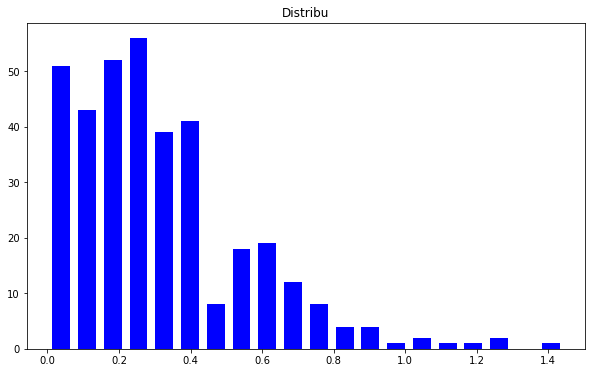

In [103]:
plt.rcParams['figure.figsize'] = [10, 6]

histogram, bins = \
            np.histogram(threshold_differences, 
                               bins   = 20,        
                               density = False )

x_coordinates = 0.5 * (bins[1:] + bins[:-1])

plt.bar(x_coordinates, histogram, width = 0.05, color = "blue");
plt.title("Distribu")

In [104]:
LOG_FC_DIFF_THRESHOLD = 0.8
level_2_counter       = 0
level_2_pause_sites   = [] 

for pause_site in differential_pause_site_df.index:
    gene, position = pause_site.split("_")
    position       = int(position)
    
    if gene in differential_cds_df.index:
        
        
        log_fc_cds        = differential_cds_df.loc[gene, "logFC"]
        log_fc_pause_site = differential_pause_site_df.loc[pause_site, "logFC"]
        log_fc_difference = abs( log_fc_cds - log_fc_pause_site)
        
        if log_fc_difference > LOG_FC_DIFF_THRESHOLD:
            level_2_counter += 1
            level_2_pause_sites.append( (pause_site, log_fc_pause_site))
            print(differential_pause_site_df.loc[pause_site,:])
            print("Difference is {}".format(log_fc_difference))
            print("----------------------")

        
print(level_2_counter)

genes     EIF4B-201_1818
logFC            2.02272
logCPM           5.75349
F                55.5096
PValue       1.41654e-09
FDR          8.97944e-06
Name: EIF4B-201_1818, dtype: object
Difference is 1.0090079950015627
----------------------
genes     DDIT4-201_249
logFC          -2.01134
logCPM          6.09445
F               40.1084
PValue      7.44913e-08
FDR           4.722e-05
Name: DDIT4-201_249, dtype: object
Difference is 0.8581652968520723
----------------------
genes     SMARCB1-213_731
logFC             1.50107
logCPM            4.54224
F                  13.222
PValue        0.000668545
FDR             0.0175847
Name: SMARCB1-213_731, dtype: object
Difference is 1.2413410191895982
----------------------
genes     DPY30-202_275
logFC           -1.4653
logCPM          5.68308
F               24.0543
PValue      1.09349e-05
FDR          0.00106641
Name: DPY30-202_275, dtype: object
Difference is 1.1978544302832106
----------------------
genes     PPA2-201_185
logFC         -1

In [105]:
#with open("level_2_diff_pause_sites.pick", "wb") as pickle_out:
#        pickle.dump(level_2_pause_sites, pickle_out)

In [106]:
#COX7A2L-202_230
coverages["20200717-WT-HEK-1-setB"][0].loc["COX7A2L-202"]

total         273.000000
length       3056.000000
cds_start     830.000000
cds_stop     1172.000000
norm_cds        0.681287
norm_cov        0.089332
Name: COX7A2L-202, dtype: float64

## Overlaps and Pause Site Mean

Based on coverage and correlation analysis we predict that coverage is very highly conserved and pause sites are common. If we sequenced more, we would get more pause sites. 
Similarly, in our data the percentage of overlapping pause sites would increase if we pick pause sites with higher values.

In [107]:
# All pause sites
#pause_sites


In [108]:


def find_pause_site_mean( pause_site, experiments, coverages ):
        gene, position    = pause_site.split("_")
        position          = int(position)
        cds_start         = coverages[experiments[0]][0].loc[gene, "cds_start"]
        adjusted_position = cds_start + int(position)
        
        pause_site_counts = [ coverages[e][1][gene][adjusted_position] for e in experiments ]
        
        ps_mean = np.mean(pause_site_counts)
        return int(ps_mean)
    
find_pause_site_mean( pause_site  = "SFT2D2-201_395", 
                      experiments = NSP1_experiments + NSP2_experiments, 
                      coverages   = coverages)    


find_pause_site_mean( pause_site  = "COX7A2L-202_230", 
                      experiments = NSP1_experiments + NSP2_experiments, 
                      coverages   = coverages)    

10

In [109]:
my_experiment_set = NSP1_experiments + NSP2_experiments

pause_site_means = { p: find_pause_site_mean( 
                                        pause_site  = p, 
                                        experiments = my_experiment_set, 
                                        coverages   = coverages) \
                      for p in all_pause_sites}

In [110]:
max(pause_site_means.values())

2819

In [111]:
len(all_pause_sites) // 20

316

In [112]:
sorted_site_items = sorted(pause_site_means.items(), key = lambda x: x[1])

bin_size = len(all_pause_sites) // 20

binned_pause_site_list = [ sorted_site_items[i*bin_size: (i+1)*bin_size] for i in range( 20 )   ]

def find_bin_mean(current_bin):
    values = [ x[1] for x in current_bin ]
    return np.mean(values)

mid_points = [ find_bin_mean(x) for x in binned_pause_site_list ]
#pause_site_means["AAMP-201_1016"]

In [114]:
def get_pause_site_names(pair_array):
    return [ x[0] for x in pair_array ]

binned_pause_site_names = [ get_pause_site_names(x) for x in binned_pause_site_list ]

In [115]:
def find_overlapping_percentage( current_pause_sites, NP1_pause_sites, NP2_pause_sites ):
    current_global       = set(current_pause_sites) 
    current_NP1_sites    = current_global.intersection(NP1_pause_sites)
    current_NP2_sites    = current_global.intersection(NP2_pause_sites)
    current_union        = current_NP1_sites.union(current_NP2_sites)
    current_intersection = current_NP1_sites.intersection(current_NP2_sites)
    if len(current_union) == 0:
        return 100
    overlap_percentage   = (len(current_intersection) / len(current_union) ) * 100
    return overlap_percentage
    

In [116]:
overlap_percentages = [ find_overlapping_percentage( x, NSP1_pause_site_set, NSP2_pause_site_set )\
                         for x in binned_pause_site_names ] 

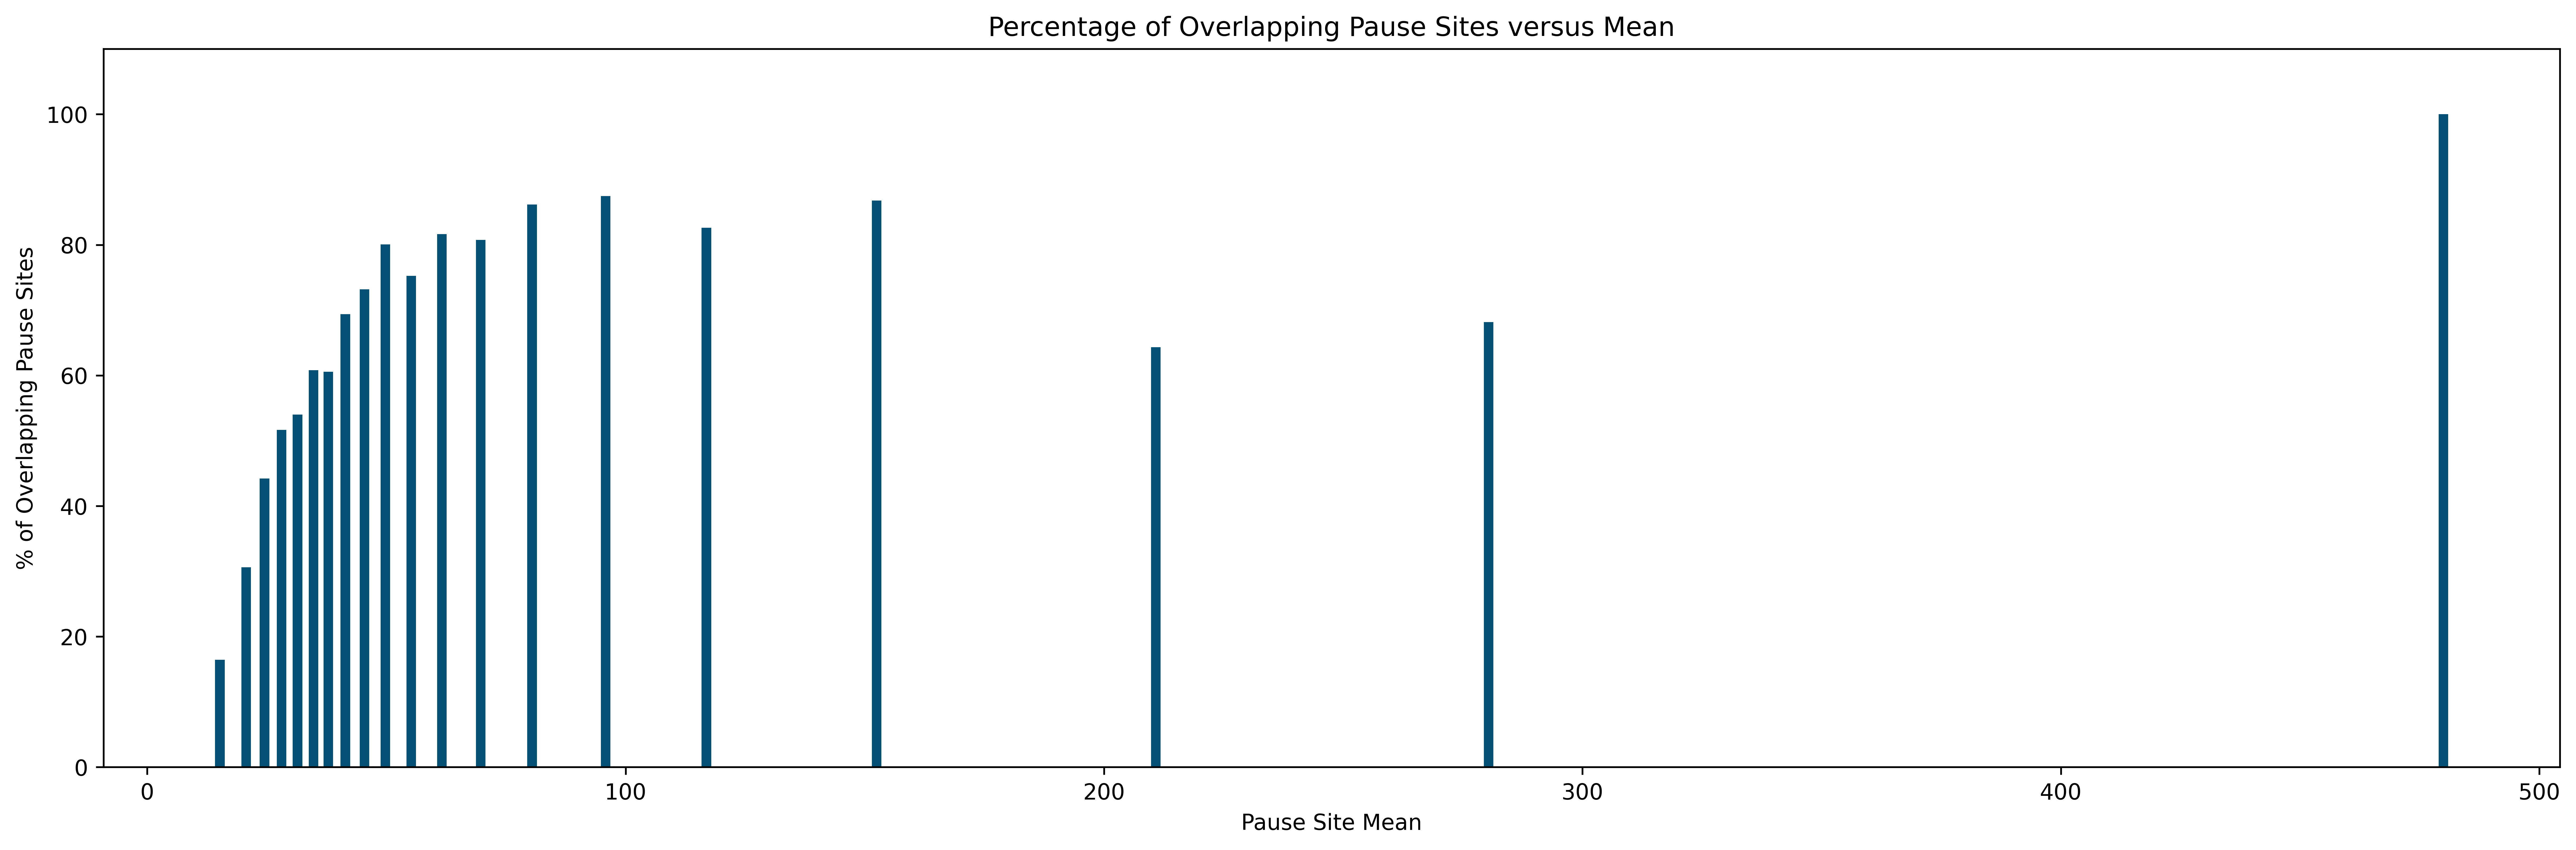

In [117]:
plt.rcParams['figure.figsize'] = [20, 6]

plt.figure( 1, (20,6),dpi = FIGURE_RESOLUTION )
#plt.set_ylim( bottom = 0, top = 100 )
plt.subplot(1,1,1)
plt.ylim(bottom = 0 , top = 110)
plt.bar( mid_points, overlap_percentages, width = 2, color = FRAME_COLORS[0] )
plt.xlabel("Pause Site Mean");
plt.ylabel("% of Overlapping Pause Sites");
plt.title( "Percentage of Overlapping Pause Sites versus Mean" );
plt.savefig("overlap_percantage_vs_mean_barplot.pdf")

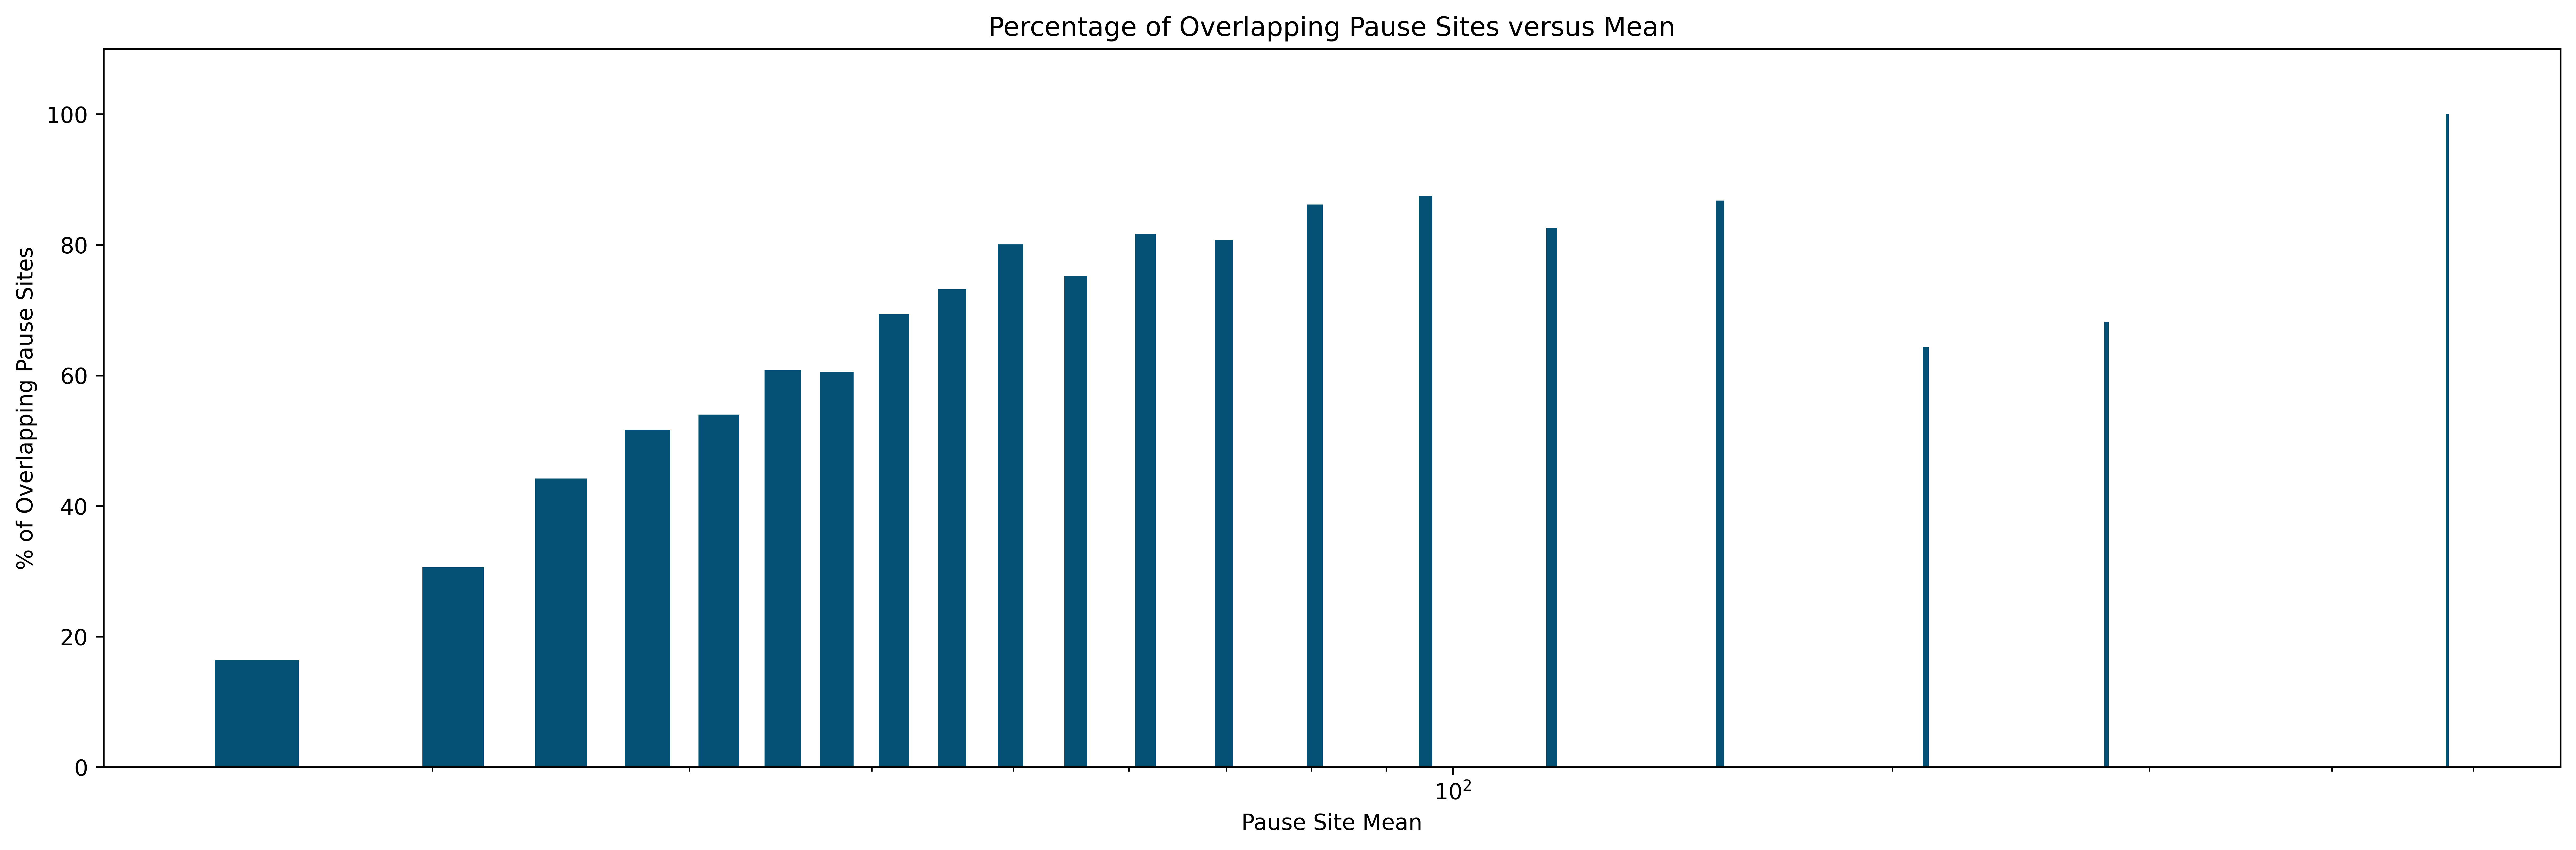

In [118]:
plt.rcParams['figure.figsize'] = [20, 6]

plt.figure( 1, (20,6),dpi = FIGURE_RESOLUTION )
#plt.set_ylim( bottom = 0, top = 100 )
plt.subplot(1,1,1)
plt.ylim(bottom = 0 , top = 110)
plt.bar( mid_points, overlap_percentages, width = 2, color = FRAME_COLORS[0] )
plt.xscale("log")
plt.xlabel("Pause Site Mean");
plt.ylabel("% of Overlapping Pause Sites");
plt.title( "Percentage of Overlapping Pause Sites versus Mean" );
#plt.savefig("overlap_percantage_vs_mean_barplot.pdf")

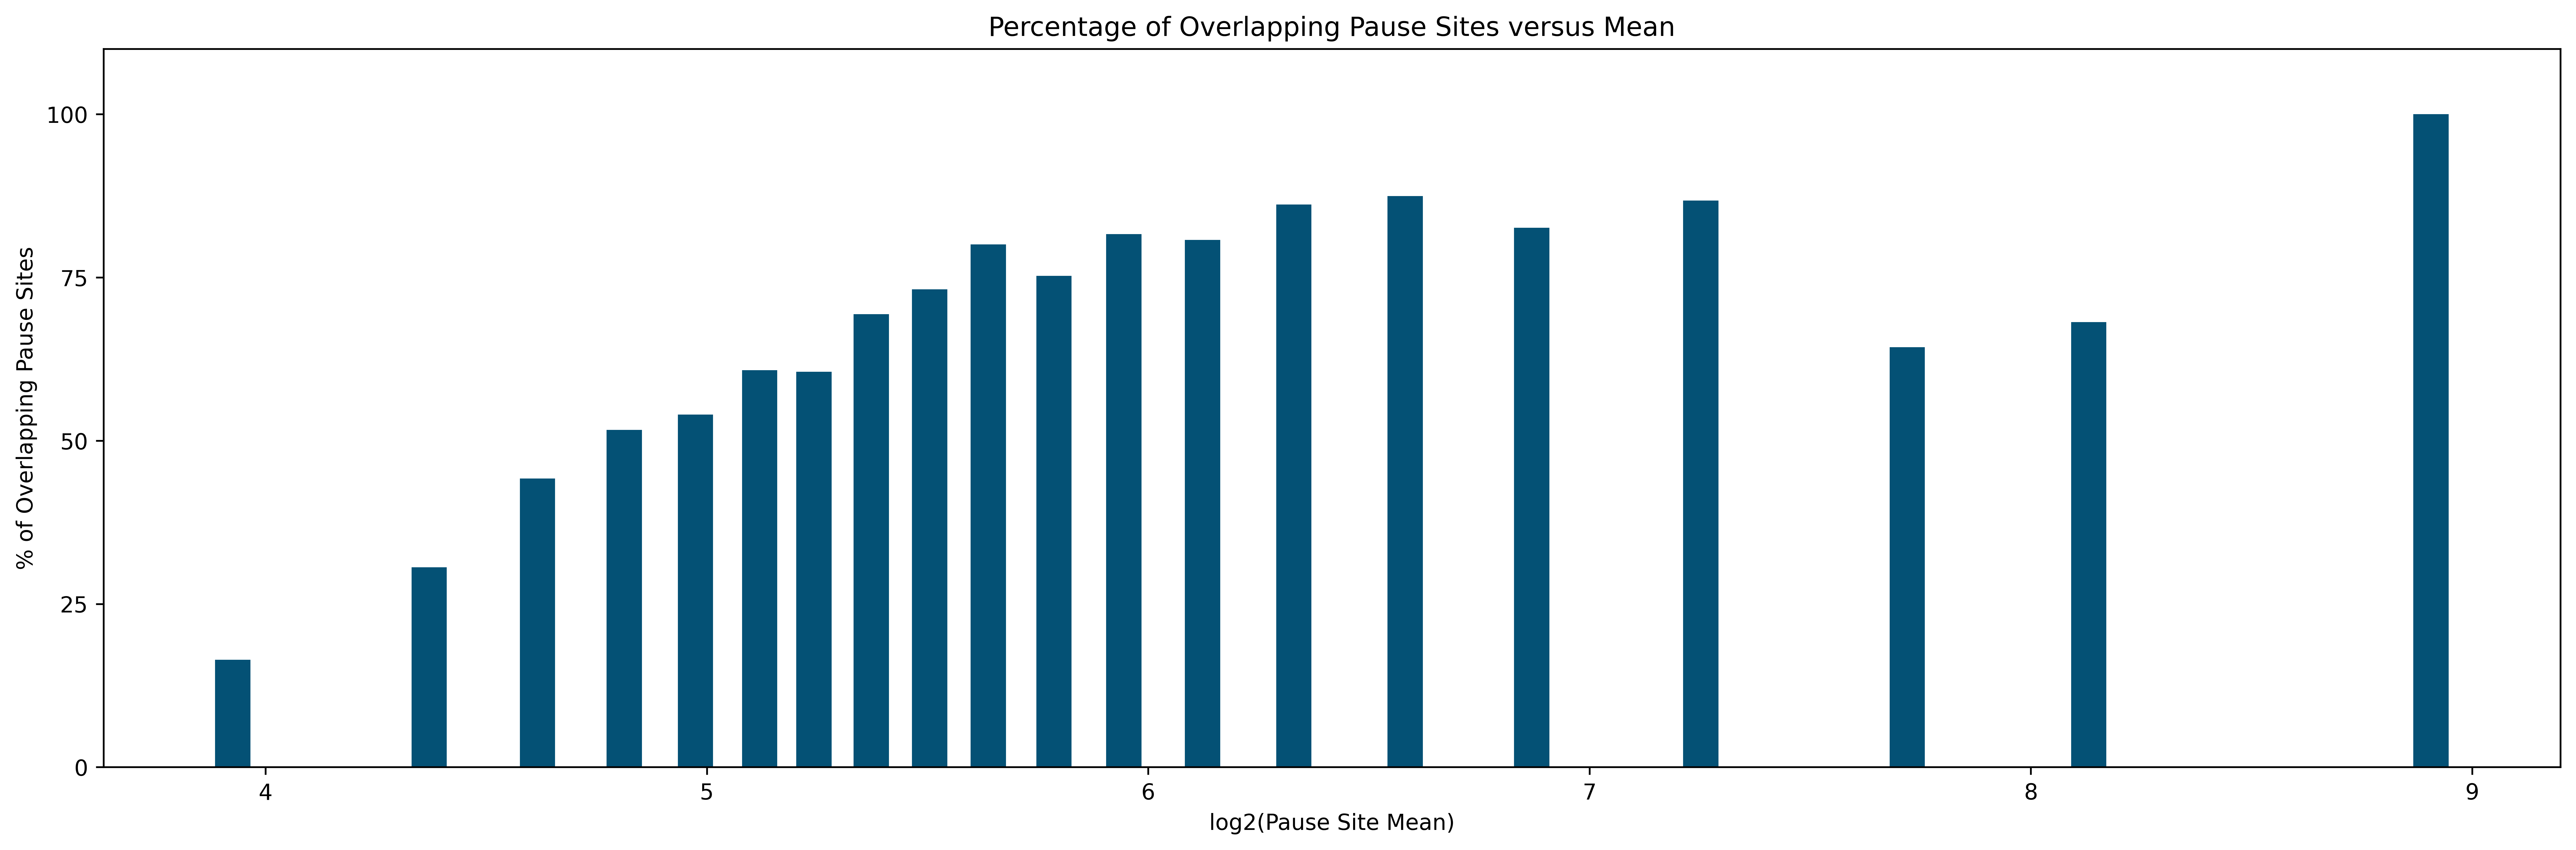

In [119]:
plt.rcParams['figure.figsize'] = [20, 6]

plt.figure( 1, (20,6),dpi = FIGURE_RESOLUTION )
#plt.set_ylim( bottom = 0, top = 100 )
barplot_yticks = (0, 25, 50, 75, 100)
plt.subplot(1,1,1)
plt.ylim(bottom = 0 , top = 110)
plt.bar( np.log2(mid_points ), overlap_percentages, width = 0.08, color = FRAME_COLORS[0] )
plt.xlabel("log2(Pause Site Mean)");
plt.ylabel("% of Overlapping Pause Sites");
plt.title( "Percentage of Overlapping Pause Sites versus Mean" );
plt.yticks( barplot_yticks, barplot_yticks );
plt.savefig("overlap_percantage_vs_mean_barplot_log_scale.pdf")

**Figure**: Percentage of overlapping pause sites, between NSP1 and NSP2, versus pause site mean. 
For each pause site, we computed the mean value of the coverage accross 6 replicates coming from NSP1 and NSP2 samples. After srting the pause sites by their means, we partitioned them into 20 sets of equal site, that we call bins. For each bin, we computed the percentage of overlapping pause sites between NSP1 and NSP2. We plot the percentage on the y-axis and the mean value of each binon the y-axis.

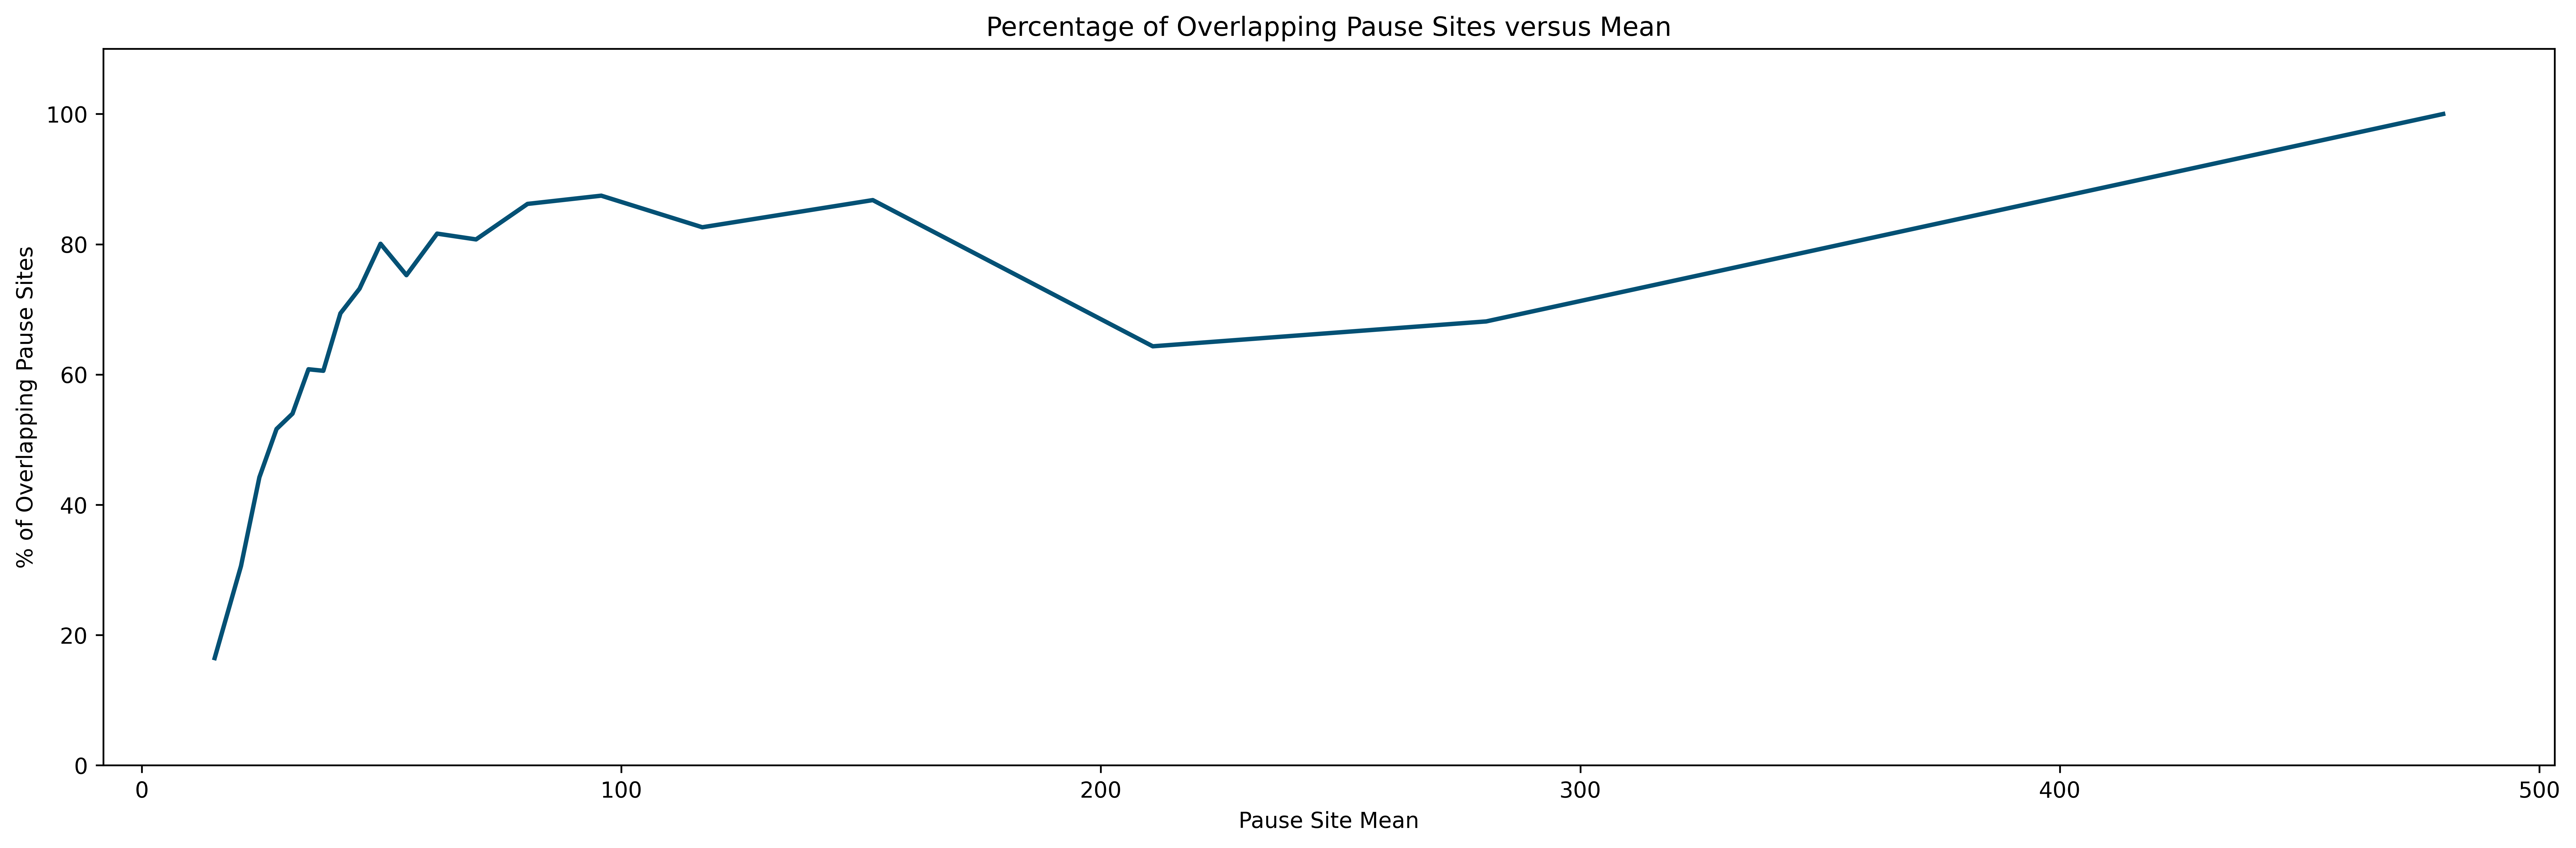

In [120]:
plt.rcParams['figure.figsize'] = [20, 6]

plt.figure( 1, (20,6),dpi = FIGURE_RESOLUTION )
#plt.set_ylim( bottom = 0, top = 110 )
plt.subplot(1,1,1)
plt.ylim(bottom = 0 , top = 110)
plt.plot( mid_points, overlap_percentages, linewidth = 2, color = FRAME_COLORS[0] )
plt.xlabel("Pause Site Mean");
plt.ylabel("% of Overlapping Pause Sites");
plt.title( "Percentage of Overlapping Pause Sites versus Mean" );
plt.savefig("overlap_percantage_vs_mean_lineplot.pdf")

**Figure**: Percentage of overlapping pause sites, between NSP1 and NSP2, versus pause site mean. 
For each pause site, we computed the mean value of the coverage accross 6 replicates coming from NSP1 and NSP2 samples. After srting the pause sites by their means, we partitioned them into 20 sets of equal site, that we call bins. For each bin, we computed the percentage of overlapping pause sites between NSP1 and NSP2. We plot the percentage on the y-axis and the mean value of each binon the y-axis.